In [5]:
# import all the necessary libraries
import pandas as pd
import numpy as np
import csv
import math
import gender_guesser.detector as gender
import nltk
import os
import pycountry

In [6]:
os.getcwd()

'C:\\Users\\dand\\Documents\\GitHub\\gender_climate_justice\\code'

In [4]:
# this is my gender identification dataframe
# using 'andy' as 0.5 isntead of excluding it 
# with this method it is imossible to quantify uncertainty around gender identification of each name 
# we can try and see what we can do with genderizeR (it provides uncertainty for each name)
# or we can try a paid tool

df_gender_m = pd.read_csv('/Users/dianadanilenko/Desktop/personal/master_thesis/methods/python_scripts/data/gender_data.csv')
df_ssa = pd.read_csv('/Users/dianadanilenko/Desktop/personal/master_thesis/methods/R_scripts/data/gender_ssa.csv', usecols = ['name','gender'])
df_ipums = pd.read_csv('/Users/dianadanilenko/Desktop/personal/master_thesis/methods/R_scripts/data/gender_ipums.csv', usecols = ['name','gender'])
df_gender_m = pd.merge(df_gender_m,df_ssa, how = 'left', on = 'name')
df_gender_m.rename(columns={'gender': 'ssa'}, inplace=True)
df_gender_m = pd.merge(df_gender_m,df_ipums, how = 'left', on = 'name')
df_gender_m.rename(columns={'gender': 'ipums'}, inplace=True)
for row in df_gender_m.index:
    if df_gender_m.loc[row,'gender_guesser'] == 'unknown':
        df_gender_m.loc[row,'gender_guesser'] = np.nan
    #elif df_gender_m.loc[row,'gender_guesser'] == 'andy':
        #df_gender_m.loc[row,'gender_guesser'] = np.nan
    elif df_gender_m.loc[row,'gender_guesser'] == 'mostly_male':
        df_gender_m.loc[row,'gender_guesser'] = 'male'
    elif df_gender_m.loc[row,'gender_guesser'] == 'mostly_female':
        df_gender_m.loc[row,'gender_guesser'] = 'female'
for row in df_gender_m.index:
    if df_gender_m.loc[row,'wiki'] == 'unknown':
        df_gender_m.loc[row,'wiki'] = np.nan
    #elif df_gender_m.loc[row,'wiki'] == 'andy':
        #df_gender_m.loc[row,'wiki'] = np.nan
df_gender_m['prob_female'] = np.nan
for row in df_gender_m.index:
    allpredictions = []
    if not pd.isna(df_gender_m.loc[row, 'gender_guesser']):
        allpredictions.append(df_gender_m.loc[row, 'gender_guesser'])
    if not pd.isna(df_gender_m.loc[row, 'ipcc']):
        splitipcc = df_gender_m.loc[row, 'ipcc'].split(',')
        for value in splitipcc:
            allpredictions.append(value)
    if not pd.isna(df_gender_m.loc[row, 'wiki']):
        allpredictions.append(df_gender_m.loc[row, 'wiki'])
    if not pd.isna(df_gender_m.loc[row, 'ssa']):
        allpredictions.append(df_gender_m.loc[row, 'ssa'])
    if not pd.isna(df_gender_m.loc[row, 'ipums']):
        allpredictions.append(df_gender_m.loc[row, 'ipums'])
    try:
        if 'andy' in allpredictions:
            df_gender_m.loc[row,'prob_female'] = (allpredictions.count('female') + 0.5 * allpredictions.count('andy'))/ len(allpredictions)    
        else:
            df_gender_m.loc[row,'prob_female'] = allpredictions.count('female')/ len(allpredictions)
    except ZeroDivisionError:
        pass

In [10]:
# load the documents and authors
# these are a full dataset of documents from query 11087 run in january 2023
# this df contains multiple entries per document id as it is split up by author
# add a column with country gender equality index based on the institutional affilliation of the first author (after consolidation, only keep one institution entry per document id)
mycolumns = ['id','abstract','title','PY','journal','category', 'author_name','institution', 'position', 'relevant', 'seen','keywords']
df = pd.read_csv('/Users/dianadanilenko/Desktop/personal/master_thesis/methods/python_scripts/data/11087_results.csv', names = mycolumns)
df = df.drop(index = 0)
df = df.drop(['relevant', 'seen'], axis=1)
df.rename(columns={'PY':'year','journal':'publisher'},inplace=True)
unique_count_id = df['id'].nunique()
print(unique_count_id)
# 70,319
display(df)
# N = 366,522 initial dataset (authorships)

70319


/Users/dianadanilenko/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,3,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,abstract,title,year,publisher,category,author_name,institution,position,keywords
1,611869,"The Vietnamese government, along with country-...",'The weather is like the game we play': Coping...,2016.0,WILEY,Area Studies; Geography,"Turner, Sarah","McGill Univ, Dept Geog, Montreal, PQ, Canada.",2.0,NaN
2,3822524,"In this review, we take stock of the last deca...",Ten years after Copenhagen: Reimagining climat...,2020.0,WILEY,Environmental Sciences & Ecology; Meteorology ...,"Castan Broto, Vanesa","Univ Sheffield, Urban Inst, Sheffield, S Yorks...",1.0,NaN
3,109136,The significant shifts in climate variables pr...,Climate change and the city: Building capacity...,2015.0,PERGAMON-ELSEVIER SCIENCE LTD,Environmental Sciences & Ecology; Public Admin...,"Handley, John","Univ Manchester, Sch Environm & Dev, Mancheste...",5.0,NaN
4,546104,Background/Context: Educators have written abo...,"School Climate: Research, Policy, Practice, an...",2009.0,TEACHERS COLL OF COLUMBIA UNIV,Education & Educational Research,"Michelli, Nicholas M.",NaN,3.0,NaN
5,3861122,This article presents a model of the environme...,Model of Carbon Footprint Assessment for the L...,2020.0,NATURE PORTFOLIO,Science & Technology - Other Topics,"Burchart-Korol, Dorota","Silesian Tech Univ, Ul Krasinskiego 8, PL-4001...",2.0,NaN
...,...,...,...,...,...,...,...,...,...,...
366518,5645675,The proceedings contain 48 papers. The special...,International Conference on Advances in Constr...,2022.0,NaN,NaN,NaN,NaN,NaN,NaN
366519,1803095,"Traditionally, biodiversity conservation gap a...",The Effects of Governmental Protected Areas an...,2009.0,NaN,NaN,NaN,NaN,NaN,NaN
366520,2378632,Lessons learned from Songkhla lake fisheries s...,Partnership-based fisheries management in Song...,2010.0,NaN,NaN,NaN,NaN,NaN,NaN
366521,5338985,The proceedings contain 48 papers. The special...,27th Annual International Scientific Conferenc...,2021.0,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df['id'] = df['id'].apply(lambda x: int(x) if isinstance(x, str) else x)

In [29]:
# drop NAs later because we don't want to keep only part of the authorships per paper
# this is the dataframe for majority_gender 
# drop duplicated authorship records
# N = 232,029 after dropping duplicates and any papers where any author name is NA
# 49,422 
df_maj = df.drop_duplicates(subset=['id', 'author_name'])
df_maj = df_maj.groupby('id').filter(lambda x: not any(x['author_name'].isna()))
unique_count_id = df_maj['id'].nunique()
print(unique_count_id)
display(df_maj)

49422


,id,abstract,title,year,publisher,category,author_name,institution,position,keywords
1,611869,"The Vietnamese government, along with country-...",'The weather is like the game we play': Coping...,2016.0,WILEY,Area Studies; Geography,"Turner, Sarah","McGill Univ, Dept Geog, Montreal, PQ, Canada.",2.0,NaN
2,3822524,"In this review, we take stock of the last deca...",Ten years after Copenhagen: Reimagining climat...,2020.0,WILEY,Environmental Sciences & Ecology; Meteorology ...,"Castan Broto, Vanesa","Univ Sheffield, Urban Inst, Sheffield, S Yorks...",1.0,NaN
3,109136,The significant shifts in climate variables pr...,Climate change and the city: Building capacity...,2015.0,PERGAMON-ELSEVIER SCIENCE LTD,Environmental Sciences & Ecology; Public Admin...,"Handley, John","Univ Manchester, Sch Environm & Dev, Mancheste...",5.0,NaN
4,546104,Background/Context: Educators have written abo...,"School Climate: Research, Policy, Practice, an...",2009.0,TEACHERS COLL OF COLUMBIA UNIV,Education & Educational Research,"Michelli, Nicholas M.",NaN,3.0,NaN
5,3861122,This article presents a model of the environme...,Model of Carbon Footprint Assessment for the L...,2020.0,NATURE PORTFOLIO,Science & Technology - Other Topics,"Burchart-Korol, Dorota","Silesian Tech Univ, Ul Krasinskiego 8, PL-4001...",2.0,NaN
...,...,...,...,...,...,...,...,...,...,...
366506,35060,Shifts in species' ranges are one of the most ...,Rapid assessment of an ocean warming hotspot r...,2015.0,ELSEVIER SCI LTD,Environmental Sciences & Ecology; Geography,"Gledhill, D. C.","CSIRO Marine & Atmospher Res, CSIRO Wealth Oce...",2.0,NaN
366508,4307291,There is a broad consensus worldwide that anth...,Humanity Can Still Stop Climate Change by Impl...,2020.0,MDPI,Energy & Fuels,"Margeta, Karmen","Univ Zagreb, Fac Chem Engn & Technol, Marulice...",2.0,NaN
366510,4912929,"Light pollution, a phenomenon in which artific...",Evaluation of Light Pollution in Global Protec...,2021.0,MDPI,Environmental Sciences & Ecology; Geology; Rem...,"Yin, Peiyi","China Agr Univ, Coll Land Sci & Technol, Beiji...",8.0,NaN
366512,1299177,This study reports the Brokpa herder's knowled...,Grazing and rangeland management: Trans-human ...,2018.0,NATL INST SCIENCE COMMUNICATION-NISCAIR,Plant Sciences,"Tsering, Darge",NaN,4.0,NaN


In [30]:
df_maj = df_maj[df_maj['id'].notna()]
unique_count_id = df_maj['id'].nunique()
print(unique_count_id)
# 49422
# N = 232027

49422


In [31]:
df_maj["first_name"] = np.nan

# try to find first name of each author and record the id if there are blanks
def extract_first_name(full_name):
    try:
        return full_name.split(",")[1]
    except IndexError:
        return np.nan

df_maj["first_name"] = df_maj["author_name"].apply(extract_first_name)
list_ids = df_maj[df_maj["first_name"].isnull()]["id"].tolist()

In [32]:
df_maj.reset_index(inplace=True, drop=True)
display(df_maj)

,id,abstract,title,year,publisher,category,author_name,institution,position,keywords,first_name
0,611869,"The Vietnamese government, along with country-...",'The weather is like the game we play': Coping...,2016.0,WILEY,Area Studies; Geography,"Turner, Sarah","McGill Univ, Dept Geog, Montreal, PQ, Canada.",2.0,NaN,Sarah
1,3822524,"In this review, we take stock of the last deca...",Ten years after Copenhagen: Reimagining climat...,2020.0,WILEY,Environmental Sciences & Ecology; Meteorology ...,"Castan Broto, Vanesa","Univ Sheffield, Urban Inst, Sheffield, S Yorks...",1.0,NaN,Vanesa
2,109136,The significant shifts in climate variables pr...,Climate change and the city: Building capacity...,2015.0,PERGAMON-ELSEVIER SCIENCE LTD,Environmental Sciences & Ecology; Public Admin...,"Handley, John","Univ Manchester, Sch Environm & Dev, Mancheste...",5.0,NaN,John
3,546104,Background/Context: Educators have written abo...,"School Climate: Research, Policy, Practice, an...",2009.0,TEACHERS COLL OF COLUMBIA UNIV,Education & Educational Research,"Michelli, Nicholas M.",NaN,3.0,NaN,Nicholas M.
4,3861122,This article presents a model of the environme...,Model of Carbon Footprint Assessment for the L...,2020.0,NATURE PORTFOLIO,Science & Technology - Other Topics,"Burchart-Korol, Dorota","Silesian Tech Univ, Ul Krasinskiego 8, PL-4001...",2.0,NaN,Dorota
...,...,...,...,...,...,...,...,...,...,...,...
232024,35060,Shifts in species' ranges are one of the most ...,Rapid assessment of an ocean warming hotspot r...,2015.0,ELSEVIER SCI LTD,Environmental Sciences & Ecology; Geography,"Gledhill, D. C.","CSIRO Marine & Atmospher Res, CSIRO Wealth Oce...",2.0,NaN,D. C.
232025,4307291,There is a broad consensus worldwide that anth...,Humanity Can Still Stop Climate Change by Impl...,2020.0,MDPI,Energy & Fuels,"Margeta, Karmen","Univ Zagreb, Fac Chem Engn & Technol, Marulice...",2.0,NaN,Karmen
232026,4912929,"Light pollution, a phenomenon in which artific...",Evaluation of Light Pollution in Global Protec...,2021.0,MDPI,Environmental Sciences & Ecology; Geology; Rem...,"Yin, Peiyi","China Agr Univ, Coll Land Sci & Technol, Beiji...",8.0,NaN,Peiyi
232027,1299177,This study reports the Brokpa herder's knowled...,Grazing and rangeland management: Trans-human ...,2018.0,NATL INST SCIENCE COMMUNICATION-NISCAIR,Plant Sciences,"Tsering, Darge",NaN,4.0,NaN,Darge


In [34]:
df_maj = df_maj[~df_maj['id'].isin(list_ids)].reset_index(drop=True)
display(df_maj)
# 224,528
unique_count_id = df_maj['id'].nunique()
print(unique_count_id)
# 48,657
"""after cleaning for studies that contain 
one or more empty first author name records 
(all authorships for such studies are erased)"""

48657


In [35]:
df_maj['name'] = np.nan

In [36]:
# clean the names
import re

# replace hyphens with spaces
df_maj['name'] = df_maj['first_name'].str.replace('-', ' ', regex=False)

# keep only the part that is not initials
def extract_non_initials(name):
    parts = re.split(r'\s+', name.strip())
    for part in parts:
        if len(part) >= 2 and not part.endswith('.'):
            return part
    return np.nan

df_maj['name'] = df_maj['name'].apply(extract_non_initials)
list_ids.extend(df_maj[df_maj['name'].isnull()]['id'])
df_maj = df_maj[~df_maj['id'].isin(list_ids)].reset_index(drop=True)

# get rid of other special symbols
special = ['(', ')']
for x in special:
    df_maj['name'] = df_maj['name'].str.replace(re.escape(x), '', regex=False)

In [38]:
display(df_maj)
# 194,505
unique_count_id = df_maj['id'].nunique()
print(unique_count_id)
# 42,742

,id,abstract,title,year,publisher,category,author_name,institution,position,keywords,first_name,name
0,611869,"The Vietnamese government, along with country-...",'The weather is like the game we play': Coping...,2016.0,WILEY,Area Studies; Geography,"Turner, Sarah","McGill Univ, Dept Geog, Montreal, PQ, Canada.",2.0,NaN,Sarah,Sarah
1,3822524,"In this review, we take stock of the last deca...",Ten years after Copenhagen: Reimagining climat...,2020.0,WILEY,Environmental Sciences & Ecology; Meteorology ...,"Castan Broto, Vanesa","Univ Sheffield, Urban Inst, Sheffield, S Yorks...",1.0,NaN,Vanesa,Vanesa
2,109136,The significant shifts in climate variables pr...,Climate change and the city: Building capacity...,2015.0,PERGAMON-ELSEVIER SCIENCE LTD,Environmental Sciences & Ecology; Public Admin...,"Handley, John","Univ Manchester, Sch Environm & Dev, Mancheste...",5.0,NaN,John,John
3,546104,Background/Context: Educators have written abo...,"School Climate: Research, Policy, Practice, an...",2009.0,TEACHERS COLL OF COLUMBIA UNIV,Education & Educational Research,"Michelli, Nicholas M.",NaN,3.0,NaN,Nicholas M.,Nicholas
4,3861122,This article presents a model of the environme...,Model of Carbon Footprint Assessment for the L...,2020.0,NATURE PORTFOLIO,Science & Technology - Other Topics,"Burchart-Korol, Dorota","Silesian Tech Univ, Ul Krasinskiego 8, PL-4001...",2.0,NaN,Dorota,Dorota
...,...,...,...,...,...,...,...,...,...,...,...,...
194500,244013,Noticeably absent from the tools and technique...,A Stakeholder Analysis of Colorado Climate and...,2013.0,WILEY-BLACKWELL,Government & Law; Public Administration,"Elgin, Dallas J.","Univ Colorado, Sch Publ Affairs, Denver, CO 80...",1.0,NaN,Dallas J.,Dallas
194501,4307291,There is a broad consensus worldwide that anth...,Humanity Can Still Stop Climate Change by Impl...,2020.0,MDPI,Energy & Fuels,"Margeta, Karmen","Univ Zagreb, Fac Chem Engn & Technol, Marulice...",2.0,NaN,Karmen,Karmen
194502,4912929,"Light pollution, a phenomenon in which artific...",Evaluation of Light Pollution in Global Protec...,2021.0,MDPI,Environmental Sciences & Ecology; Geology; Rem...,"Yin, Peiyi","China Agr Univ, Coll Land Sci & Technol, Beiji...",8.0,NaN,Peiyi,Peiyi
194503,1299177,This study reports the Brokpa herder's knowled...,Grazing and rangeland management: Trans-human ...,2018.0,NATL INST SCIENCE COMMUNICATION-NISCAIR,Plant Sciences,"Tsering, Darge",NaN,4.0,NaN,Darge,Darge


42742


In [39]:
df_maj = pd.merge(df_maj, df_gender_m[['name','prob_female']], how = 'left', on = 'name')

In [41]:
df_maj['prob_female'].value_counts().sum()
# 178325

178325

In [43]:
df_maj['author_female'] = np.where(df_maj['prob_female'] >= 0.75, 1,
                                     np.where(df_maj['prob_female'] <= 0.25, 0, np.nan))

In [45]:
df_maj['author_female'].value_counts()
# 168344
# 111,457 male
# 56,887 female

0.0    111457
1.0     56887
Name: author_female, dtype: int64

In [46]:
list_ids1 = df_maj[df_maj["author_female"].isnull()]["id"].tolist()

In [48]:
df_maj = df_maj[~df_maj['id'].isin(list_ids1)].reset_index(drop=True)
display(df_maj)
# 104,895
unique_count_id = df_maj['id'].nunique()
print(unique_count_id)
# 27,712  

,id,abstract,title,year,publisher,category,author_name,institution,position,keywords,first_name,name,prob_female,author_female
0,611869,"The Vietnamese government, along with country-...",'The weather is like the game we play': Coping...,2016.0,WILEY,Area Studies; Geography,"Turner, Sarah","McGill Univ, Dept Geog, Montreal, PQ, Canada.",2.0,NaN,Sarah,Sarah,1.00,1.0
1,3822524,"In this review, we take stock of the last deca...",Ten years after Copenhagen: Reimagining climat...,2020.0,WILEY,Environmental Sciences & Ecology; Meteorology ...,"Castan Broto, Vanesa","Univ Sheffield, Urban Inst, Sheffield, S Yorks...",1.0,NaN,Vanesa,Vanesa,1.00,1.0
2,109136,The significant shifts in climate variables pr...,Climate change and the city: Building capacity...,2015.0,PERGAMON-ELSEVIER SCIENCE LTD,Environmental Sciences & Ecology; Public Admin...,"Handley, John","Univ Manchester, Sch Environm & Dev, Mancheste...",5.0,NaN,John,John,0.00,0.0
3,546104,Background/Context: Educators have written abo...,"School Climate: Research, Policy, Practice, an...",2009.0,TEACHERS COLL OF COLUMBIA UNIV,Education & Educational Research,"Michelli, Nicholas M.",NaN,3.0,NaN,Nicholas M.,Nicholas,0.00,0.0
4,3861122,This article presents a model of the environme...,Model of Carbon Footprint Assessment for the L...,2020.0,NATURE PORTFOLIO,Science & Technology - Other Topics,"Burchart-Korol, Dorota","Silesian Tech Univ, Ul Krasinskiego 8, PL-4001...",2.0,NaN,Dorota,Dorota,1.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104890,4168410,Deforestation is an environmental stressor tha...,Application of Remote Sensing for Ex ante Deci...,2022.0,SAGE PUBLICATIONS INC,Social Sciences - Other Topics,"McCartney, Sean","Goddard Space Flight Ctr, NASA DEVELOP Natl Pr...",4.0,NaN,Sean,Sean,0.00,0.0
104891,244013,Noticeably absent from the tools and technique...,A Stakeholder Analysis of Colorado Climate and...,2013.0,WILEY-BLACKWELL,Government & Law; Public Administration,"Elgin, Dallas J.","Univ Colorado, Sch Publ Affairs, Denver, CO 80...",1.0,NaN,Dallas J.,Dallas,0.00,0.0
104892,4307291,There is a broad consensus worldwide that anth...,Humanity Can Still Stop Climate Change by Impl...,2020.0,MDPI,Energy & Fuels,"Margeta, Karmen","Univ Zagreb, Fac Chem Engn & Technol, Marulice...",2.0,NaN,Karmen,Karmen,0.75,1.0
104893,1299177,This study reports the Brokpa herder's knowled...,Grazing and rangeland management: Trans-human ...,2018.0,NATL INST SCIENCE COMMUNICATION-NISCAIR,Plant Sciences,"Tsering, Darge",NaN,4.0,NaN,Darge,Darge,0.00,0.0


27712


In [50]:
columns_to_process = ['prob_female', 'author_female', 'position','name']

for col in columns_to_process:
    df_maj[col] = df_maj[col].astype(str)

In [51]:
# groupby ('id') 
df_maj = df_maj.groupby('id').agg({'author_name': lambda x: '; '.join(x),
                                   'name': lambda x: '; '.join(x),
                               'abstract': 'first',
                               'year': 'first',
                               'publisher': 'first',
                               'category': 'first',
                                   'title': 'first',
                                   'position': lambda x: '; '.join((x)),
                                 'prob_female': lambda x: '; '.join(x),
                                  'author_female': lambda x: '; '.join(x)})
display(df_maj)
# final N = 27,712

,author_name,name,abstract,year,publisher,category,title,position,prob_female,author_female
id,,,,,,,,,,
157,"Thompson, John; Scoones, Ian",John; Ian,The 'modernist' project that has come to domin...,2009.0,ELSEVIER SCI LTD,Environmental Sciences & Ecology,Addressing the dynamics of agri-food systems: ...,1.0; 1.0,0.0; 0.0,0.0; 0.0
195,"Beermann, Marina",Marina,"Within modern society, business organizations ...",2011.0,ELSEVIER SCI LTD,Science & Technology - Other Topics; Engineeri...,Linking corporate climate adaptation strategie...,1.0,1.0,1.0
222,"Lenzholzer, Sanda",Sanda,Human thermal comfort in urban outdoor places ...,2012.0,ELSEVIER SCIENCE BV,Engineering; Environmental Sciences & Ecology,Research and design for thermal comfort in Dut...,0.0,1.0,1.0
300,"Medellin-Azuara, Josue; Howitt, Richard E.; Ha...",Josue; Richard; Julien,Given the high proportion of water used for ag...,2010.0,ELSEVIER SCIENCE BV,Environmental Sciences & Ecology,Estimating economic value of agricultural wate...,1.0; 3.0; 2.0,0.0; 0.0; 0.0,0.0; 0.0; 0.0
332,"Dobremez, Laurent; Artaux, Alois; Nettier, Bap...",Laurent; Alois; Baptiste; Sandra; Penelope; Ce...,Mountain grassland ecosystems are particularly...,2013.0,ELSEVIER,Environmental Sciences & Ecology; Geography; P...,Taking into account farmers' decision making t...,4.0; 2.0; 5.0; 6.0; 1.0; 3.0,0.0; 0.0; 0.0; 1.0; 1.0; 1.0,0.0; 0.0; 0.0; 1.0; 1.0; 1.0
...,...,...,...,...,...,...,...,...,...,...
5491742,"Sokolowska, Joanna; Fuchs, Hanna; Wiland-Szyma...",Joanna; Hanna; Justyna; Konrad; Petr,The Socotra dragon`s blood tree (Dracaena cinn...,2022.0,MDPI,Forestry,Characterization of the Complete Chloroplast G...,2.0; 3.0; 5.0; 1.0; 4.0,1.0; 1.0; 1.0; 0.0; 0.0,1.0; 1.0; 1.0; 0.0; 0.0
5491809,"Strachan, Laura L.; Lilley, Richard J.; Hennig...",Laura; Richard; Sebastian,Seagrass meadows provide a range of key ecosys...,2022.0,ELSEVIER SCI LTD,Environmental Sciences & Ecology; Internationa...,A regional and international framework for eva...,1.0; 2.0; 3.0,1.0; 0.0; 0.0,1.0; 0.0; 0.0
5495065,"Johnson, Cheryl A.; Drever, C. Ronnie; Kirby, ...",Cheryl; Ronnie; Patrick; Amanda; Erin,Boreal caribou require large areas of undistur...,2022.0,NATURE PORTFOLIO,Science & Technology - Other Topics,Protecting boreal caribou habitat can help con...,1.0; 2.0; 3.0; 5.0; 4.0,1.0; 0.0; 0.0; 1.0; 1.0,1.0; 0.0; 0.0; 1.0; 1.0


In [52]:
df_maj['number_authors'] = df_maj['position'].apply(lambda x: len([float(number) for number in str(x).split(";")]))

In [54]:
# save output at this stage
df_maj.to_csv("data/df_maj_1008.csv")

In [61]:
df_maj = pd.read_csv("data/df_maj_1008.csv")

# add all the remaining variables for this dataset

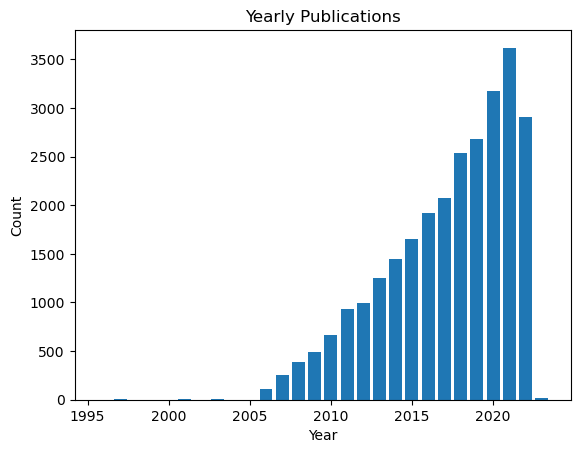

In [51]:
import matplotlib.pyplot as plt

# grouping by 'year' and count occurrences
year_counts = df_maj['year'].value_counts().sort_index()

# create a histogram
plt.bar(year_counts.index, year_counts.values)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Yearly Publications')
plt.show()

In [62]:
df_maj['category'] = df_maj['category'].str.split(';').str[0]
df_maj['category'] = df_maj['category'].astype(str)

In [38]:
# this is if we want to get to 4 broad scientific fields

df_maj['category'] = df_maj['category'].apply(lambda x: 'Natural sciences' if 'biology' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Natural sciences' if 'chemistry' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Natural sciences' if 'physics' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Natural sciences' if 'astronom' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Humanities & social sciences' if 'anthropology' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Humanities & social sciences' if 'history' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Humanities & social sciences' if 'philosophy' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Humanities & social sciences' if 'religion' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Economics' if 'economics' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Humanities & social sciences' if 'geography' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Humanities & social sciences' if 'psychology' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Humanities & social sciences' if 'sociology' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Humanities & social sciences' if 'polit' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Formal sciences' if 'computer' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Formal sciences' if 'mathematics' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Formal sciences' if 'statistics' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Formal sciences' if 'systems' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Professions & applied sciences' if 'agriculture' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Professions & applied sciences' if 'architecture' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Professions & applied sciences' if 'education' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Professions & applied sciences' if 'medicine' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Professions & applied sciences' if 'military' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Professions & applied sciences' if 'Professions & applied sciences' in x else x)

categories = df_maj['category'].value_counts().sort_index()

In [39]:
print(categories)

Acoustics                 2
Allergy                   6
Anatomy & Morphology      3
Anesthesiology            2
Archaeology              19
                       ... 
Virology                  2
Water Resources         444
Women's Studies           8
Zoology                  78
nan                     100
Name: category, Length: 91, dtype: int64


In [44]:
# do a mapping by subfield ? aka medicine, sociology, biology, etc? 

category_mapping = { "Acoustics" : "Natural sciences",
                    "Allergy": "Professions & applied sciences",
                    "Anatomy & Morphology" : "Natural sciences",
                    "Anesthesiology" : "Professions & applied sciences",
                    "Archaeology" : "Humanities & social sciences",
                    "Architecture" : "Professions & applied sciences",
                    "Area Studies" : "Humanities & social sciences",
                    "Art" : "Humanities & social sciences",
                    "Arts & Humanities - Other Topics" : "Humanities & social sciences",
                    "Behavioral Sciences" : "Humanities & social sciences",
                    "Biodiversity & Conservation" : "Natural sciences",
                    "Cardiovascular System & Cardiology" : "Professions & applied sciences",
                    "Communication" : "Humanities & social sciences",
                    "Construction & Building Technology" : "Professions & applied sciences",
                    "Criminology & Penology" : "Humanities & social sciences",
                    "Cultural Studies" : "Humanities & social sciences",
                    "Demography" : "Humanities & social sciences",
                    "Dermatology" : "Professions & applied sciences",
                    "Development Studies": "Humanities & social sciences",
                    "Economics" : "Humanities & social sciences",
                    "Endocrinology & Metabolism" : "Natural sciences",
                    "Energy & Fuels" : "Professions & applied sciences",
                    "Engineering" : "Professions & applied sciences",
                    "Entomology" : "Natural sciences",
                    "Environmental Sciences & Ecology" : "Professions & applied sciences",
                    "Ethnic Studies" : "Professions & applied sciences",
                    "Family Studies" : "Humanities & social sciences",
                    "Film, Radio & Television" : "Professions & applied sciences",
                    "Fisheries" : "Professions & applied sciences",
                    "Food Science & Technology" : "Professions & applied sciences", 
                    "Forestry" : "Professions & applied sciences",
                    "Genetics & Heredity" : "Natural sciences",
                    "Geology" : "Natural sciences",
                    "Geriatrics & Gerontology" : "Professions & applied sciences",
                    "Government & Law" : "Professions & applied sciences",
                    "Health Care Sciences & Services" : "Professions & applied sciences",
                    "Immunology" : "Professions & applied sciences",
                    "Infectious Diseases" : "Professions & applied sciences",
                    "Information Science & Library Science" : "Formal sciences",
                    "Instruments & Instrumentation" : "Professions & applied sciences",
                    "International Relations" : "Humanities & social sciences",
                    "Materials Science" : "Professions & applied sciences",
                    "Medical Informatics" : "Professions & applied sciences",
                    "Metallurgy & Metallurgical Engineering" : "Professions & applied sciences",
                    "Meteorology & Atmospheric Sciences" : "Natural sciences",
                    "Mining & Mineral Processing" : "Professions & applied sciences",
                    "Mycology" : "Natural sciences",
                    "Neurosciences & Neurology" : "Natural sciences",
                    "Nuclear Science & Technology" : "Professions & applied sciences",
                    "Nursing" : "Professions & applied sciences",
                    "Nutrition & Dietetics" : "Professions & applied sciences",
                    "Obstetrics & Gynecology" : "Professions & applied sciences",
                    "Oceanography" : "Natural sciences",
                    "Oncology" : "Professions & applied sciences",
                    "Operations Research & Management Science" : "Professions & applied sciences",
                    "Ophthalmology" : "Professions & applied sciences",
                    "Paleontology" : "Natural sciences",
                    "Parasitology" : "Natural sciences",
                    "Pediatrics" : "Professions & applied sciences",
                    "Pharmacology & Pharmacy" : "Professions & applied sciences",
                    "Physiology" : "Natural sciences",
                    "Plant Sciences" : "Natural sciences",
                    "Polymer Science" : "Professions & applied sciences",
                    "Psychiatry" : "Professions & applied sciences",
                    "Public Administration " : "Professions & applied sciences",
                    "Public, Environmental & Occupational Health" : "Professions & applied sciences",
                    "Rehabilitation" : "Professions & applied sciences", 
                    "Remote Sensing" : "Natural sciences",
                    "Respiratory System" : "Professions & applied sciences",
                    "Robotics" : "Formal sciences",
                    "Science & Technology - Other Topics" : "Humanities & social sciences",
                    "Social Issues" : "Humanities & social sciences",
                    "Social Sciences - Other Topics" : "Humanities & social sciences",
                    "Social Work" : "Professions & applied sciences",
                    "Sport Sciences" : "Professions & applied sciences",
                    "Substance Abuse" : "Professions & applied sciences",
                    "Telecommunications" :  "Professions & applied sciences",
                    "Thermodynamics" : "Natural sciences",
                    "Toxicology" :  "Professions & applied sciences",
                    "Transportation" :  "Professions & applied sciences",
                    "Urban Studies" :  "Professions & applied sciences",
                    "Urology & Nephrology" :  "Professions & applied sciences",
                    "Veterinary Sciences" :  "Professions & applied sciences",
                    "Virology" : "Natural sciences",
                    "Water Resources" : "Natural sciences",
                    "Women's Studies" : "Humanities & social sciences",
                    "Zoology" : "Natural sciences",
                    "Natural sciences" : "Natural sciences",
                    "Humanities & social sciences" : "Humanities & social sciences",
                    "Formal sciences" : "Formal sciences",
                    "Professions & applied sciences" : "Professions & applied sciences"}

# apply the mapping in a new column
df_maj['field'] = df_maj['category'].map(category_mapping)

In [66]:
# mapping into subfields
subfield_list = ["Anthropology", "History", "Linguistics & languages", "Philosophy", "Religion", "The arts", "Economics", "Geography", "Interdisciplinary", "Political science", "Psychology", "Sociology", "Biology", "Chemistry", "Earth sciences", "Physics", "Space sciences", "Computer sciences", "Logic", "Mathematics", "Systems science", "Agriculture", "Architecture & design", "Business", "Divinity", "Education", "Engineering & technology", "Environmental studies & forestry", "Medicine","Law", "Public administration", "Transportation"]

# this still needs a bit of work - some categories that i had gotten rid of in the previous run are missing

category_mapping2 = {
        "Acoustics": "Physics",
        "Allergy": "Medicine",
        "Anatomy & Morphology": "Biology",
        "Anesthesiology": "Medicine",
        "Archaeology": "Anthropology",
        "Architecture": "Architecture & design",
        "Area Studies": "Interdisciplinary",
        "Art": "The arts",
        "Arts & Humanities - Other Topics": "Interdisciplinary",
        "Behavioral Sciences": "Psychology",
        "Biodiversity & Conservation": "Biology",
        "Cardiovascular System & Cardiology": "Medicine",
        "Communication": "Interdisciplinary",
        "Construction & Building Technology": "Engineering & technology",
        "Criminology & Penology": "Sociology",
        "Cultural Studies": "Interdisciplinary",
        "Demography": "Sociology",
        "Dermatology": "Medicine",
        "Development Studies": "Interdisciplinary",
        "Economics": "Economics",
        "Endocrinology & Metabolism": "Medicine",
        "Energy & Fuels": "Physics",
        "Engineering": "Engineering & technology",
        "Entomology": "Biology",
        "Environmental Sciences & Ecology": "Environmental studies & forestry",
        "Ethnic Studies": "Interdisciplinary",
        "Family Studies": "Sociology",
        "Film, Radio & Television": "The arts",
        "Fisheries": "Biology",
        "Food Science & Technology": "Agriculture",
        "Forestry": "Environmental studies & forestry",
        "Genetics & Heredity": "Biology",
        "Geology": "Earth sciences",
        "Geriatrics & Gerontology": "Medicine",
        "Government & Law": "Political science",
        "Health Care Sciences & Services": "Medicine",
        "Immunology": "Biology",
        "Infectious Diseases": "Medicine",
        "Information Science & Library Science": "Computer sciences",
        "Instruments & Instrumentation": "Physics",
        "International Relations": "Political science",
        "Materials Science": "Engineering & technology",
        "Medical Informatics": "Computer sciences",
        "Metallurgy & Metallurgical Engineering": "Engineering & technology",
        "Meteorology & Atmospheric Sciences": "Earth sciences",
        "Mining & Mineral Processing": "Engineering & technology",
        "Mycology": "Biology",
        "Neurosciences & Neurology": "Biology",
        "Nuclear Science & Technology": "Physics",
        "Nursing": "Medicine",
        "Nutrition & Dietetics": "Medicine",
        "Obstetrics & Gynecology": "Medicine",
        "Oceanography": "Earth sciences",
        "Oncology": "Medicine",
        "Operations Research & Management Science": "Business",
        "Ophthalmology": "Medicine",
        "Paleontology": "Biology",
        "Parasitology": "Biology",
        "Pediatrics": "Medicine",
        "Pharmacology & Pharmacy": "Medicine",
        "Physiology": "Biology",
        "Plant Sciences": "Biology",
        "Polymer Science": "Chemistry",
        "Psychiatry": "Medicine",
        "Public Administration": "Public administration",
        "Public, Environmental & Occupational Health": "Medicine",
        "Rehabilitation": "Medicine",
        "Remote Sensing": "Earth sciences",
        "Respiratory System": "Medicine",
        "Robotics": "Engineering & technology",
        "Science & Technology - Other Topics": "Interdisciplinary",
        "Social Issues": "Sociology",
        "Social Sciences - Other Topics": "Interdisciplinary",
        "Social Work": "Sociology",
        "Sport Sciences": "Medicine",
        "Substance Abuse": "Medicine",
        "Telecommunications": "Engineering & technology",
        "Thermodynamics": "Physics",
        "Toxicology": "Medicine",
        "Transportation": "Transportation",
        "Urban Studies": "Geography",
        "Urology & Nephrology": "Medicine",
        "Veterinary Sciences": "Agriculture",
        "Virology": "Biology",
        "Water Resources": "Geography",
        "Women's Studies": "Sociology",
        "Zoology": "Biology",
        "Business & Economics" : "Economics",
        "Geography": "Geography",
        "Agriculture": "Agriculture",
        "Chemistry": "Chemistry",
        "Marine & Freshwater Biology": "Biology",
        "Life Sciences & Biomedicine - Other Topics": "Biology",
        "Microbiology": "Biology",
        "Physical Geography": "Geography",
        "Biotechnology & Applied Microbiology": "Biology",
        "Biochemistry & Molecular Biology": "Biology",
        "Anthropology": "Anthropology",
        "Cell Biology": "Biology",
        "Education & Educational Research": "Education",
        "Computer Science": "Computer sciences",
        "Evolutionary Biology": "Biology",
        "General & Internal Medicine": "Medicine",
        "History & Philosophy of Science": "History",
        "Sociology": "Sociology",
        "Automation & Control Systems": "Engineering & technology",
        "Mathematics": "Mathematics",
        "Geochemistry & Geophysics": "Earth sciences",
        "Psychology": "Psychology",
        "Physics": "Physics",
        "Biophysics": "Physics",
        "History": "History",
        "Emergency Medicine": "Medicine",
        "Philosophy": "Philosophy",
        "Mathematical & Computational Biology": "Biology",
        "Tropical Medicine": "Medicine",
        "Astronomy & Astrophysics": "Physics",
        "nan": "Unknown",
        "Reproductive Biology": "Biology",
        "Developmental Biology": "Biology",
        "Religion": "Religion",
        "Electrochemistry": "Chemistry",
    }

# apply the mapping in a new column
df_maj['subfield'] = df_maj['category'].map(category_mapping2)

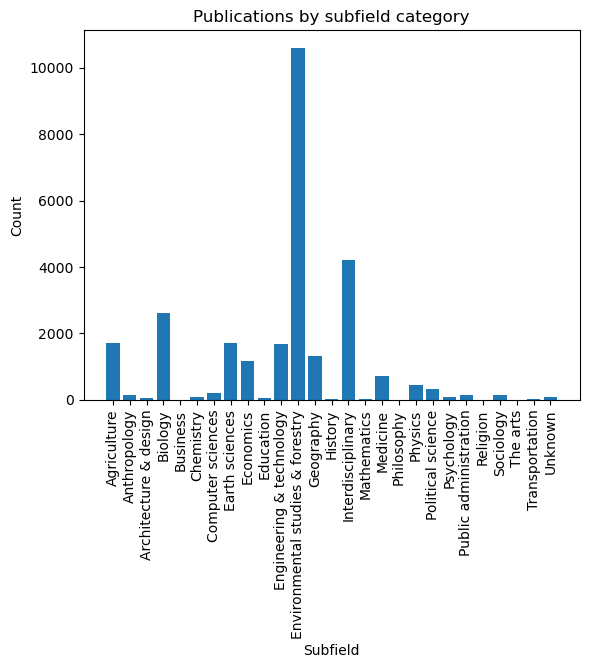

In [69]:
# group by 'year' and count occurrences
subfield_counts = df_maj['subfield'].value_counts().sort_index()

# create a histogram
plt.bar(subfield_counts.index, subfield_counts.values)
plt.xlabel('Subfield')
plt.ylabel('Count')
plt.title('Publications by subfield category')
plt.xticks(subfield_counts.index, rotation='vertical')

plt.show()

In [70]:
df_maj.to_csv("data/df_maj_1408.csv")

# introduce 'unknown' as a factor level for gender - thus keeping all the documents in the dataset 

In [56]:
def calculate_majority_female(prob_string):
    try:
        probabilities = [float(x) for x in prob_string.split(';')]
        return sum(probabilities) / len(probabilities)
    except (ValueError, ZeroDivisionError):
        return np.nan

df_maj['majority_female'] = df_maj['author_female'].apply(calculate_majority_female)

In [59]:
df_maj['majority_female'].value_counts()

27712

In [67]:
df_maj['majority_female_binary'] = np.where(df_maj['majority_female'] > 0.5, 1,
                                     np.where(df_maj['majority_female'] < 0.5, 0, np.nan))

In [69]:
df_maj['majority_female_binary'].value_counts()

# 27712 ALL
# 6338 majority female (22,87%) 
# 17169 majotiy male (61,96%)
# 4205 with gender parity (15,17%)

# save output at this stage
df_maj.to_csv("data/df_maj_1008.csv")

In [4]:
df_maj= pd.read_csv("data/df_maj_1008.csv")

In [ ]:
### df_first and df_last ### 

In [70]:
# drop rows with missing author name values
# we are already taking the "full name" field in here, but some of them still are initials
df = df[df['author_name'].notna()]
unique_count_id = df['id'].nunique()
print(unique_count_id)
# N = 49,422 after empty records

49422


In [71]:
df = df[df['id'].notna()]
unique_count_id = df['id'].nunique()
print(unique_count_id)
# 49,422

49422


In [72]:
df['author_name'] = df['author_name'].astype(str)
df['institution'] = df['institution'].astype(str)
df['position'] = df['position'].astype(str)
# here, we create a dataframe for first_author_gender and another one for last_author_gender
df_first = pd.DataFrame()
df_last = pd.DataFrame()
# group by id and aggregate the other columns
df_first = df.groupby('id').agg({'author_name': lambda x: '; '.join(x), 
                               'institution': lambda x: '; '.join(x),
                               'position': lambda x: '; '.join(x),
                               'abstract': 'first',
                               'year': 'first',
                               'publisher': 'first',
                               'category': 'first',
                              'title': 'first'})
df_last = df.groupby('id').agg({'author_name': lambda x: '; '.join(x), 
                               'institution': lambda x: '; '.join(x),
                               'position': lambda x: '; '.join(x),
                               'abstract': 'first',
                               'year': 'first',
                               'publisher': 'first',
                               'category': 'first',
                              'title': 'first'})

# rename the aggregated column and reset the index
df_first = df_first.rename(columns={'author_name': 'authors_names'}).reset_index()
df_last = df_last.rename(columns={'author_name': 'authors_names'}).reset_index()

In [ ]:
# exclude economics papers from these variables as author order is alphabetical
df_first = df_first[~df_first['subfield']=='Economics']
df_last = df_last[~df_last['subfield']=='Economics']

In [74]:
# clean up assigned author positions
def process_positions(position_string):
    positions_list = [float(number) for number in position_string.split(";")]
    if any(number == 0.0 for number in positions_list):
        positions_list = [str(number + 1) for number in positions_list]
    else:
        positions_list = [str(number) for number in positions_list]
    return ';'.join(positions_list)

df_first['position'] = df_first['position'].apply(process_positions)

In [75]:
df_last['position'] = df_last['position'].apply(process_positions)
# get rid of single-authored papers for this dataset
df_last = df_last[~(len(df_last['position'].split(";"))<=1)]

In [76]:
df_first["first_author"] = np.nan
df_last["last_author"] = np.nan

In [77]:
# let's look at the single authored papers
# at this stage df_first and df_last are exactly the same
df_single = df_first[df_first['position'].str.split(';').apply(len)==1]

In [78]:
display(df_single)
# 2,124 

,id,authors_names,institution,position,abstract,year,publisher,category,title,first_author
15,880,"James, Philip A. S.","['Univ York, Dept Environm, York YO10 5DD, N Y...",1.0,"As part of ongoing economic reforms, the Ugand...",2010.0,WILEY,Development Studies,Using Farmers' Preferences to Assess Developme...,NaN
19,1173,"Urban, Frauke","Univ Groningen, NL-9700 AB Groningen, Netherla...",1.0,Climate change adaptation and mitigation needs...,2010.0,WILEY,Area Studies; Development Studies,The MDGs and Beyond: Can Low Carbon Developmen...,NaN
53,2889,"Botella, Alberic","Univ Ottawa, Inst Environm, Dept Sci Terre, Ot...",1.0,"Over the coming decades, sea-level rise will i...",2016.0,TAYLOR & FRANCIS LTD,Water Resources,Regional projections of Sea-level Rise in Fren...,NaN
102,6282,"Priyadarshan, P. M.","Rubber Res Inst India Erstwhile, 9 Neelanjali,...",1.0,Hevea brasiliensis (Willd. Ex. A. de. Juss. Mu...,2017.0,SPRINGER HEIDELBERG,Forestry; Genetics & Heredity; Agriculture,Refinements to Hevea rubber breeding,NaN
128,8366,"Muller, Scott A.","CODESTA, Panama City, Panama.",1.0,Climate change is one of the defining issues f...,2011.0,WILEY,Dermatology,"Climate change, dermatology and ecosystem serv...",NaN
...,...,...,...,...,...,...,...,...,...,...
49286,5415392,"Stephens, Jennie C.","Northeastern Univ, Sch Publ Policy & Urban Aff...",1.0,Purpose of Review This review explores how mor...,None,SPRINGER HEIDELBERG,Meteorology & Atmospheric Sciences,Beyond Climate Isolationism: a Necessary Shift...,NaN
49311,5435294,"Petrucci, Olga","CNR IRPI Res Inst Geohydrol Protect, Via Cavou...",1.0,Landslides triggered by rainfall kill people w...,2022.0,MDPI,Science & Technology - Other Topics; Environme...,Landslide Fatality Occurrence: A Systematic Re...,NaN
49318,5437279,[Anonymous],[''],1.0,"Carbon dioxide reductions are key, but the IPC...",2021.0,NATURE PORTFOLIO,Science & Technology - Other Topics,Control methane to slow global warming - fast,NaN
49326,5439450,"Booker, James F.","Siena Coll, Econ Dept, Loudonville, NY 12211 USA.",1.0,Water availability to meet consumptive use dem...,2022.0,WILEY,Engineering; Geology; Water Resources,Colorado River Water Use and Climate: Model an...,NaN


In [80]:
df_last = df_last[~df_last['id'].isin(df_single['id'])].reset_index(drop=True)

In [82]:
display(df_first)
# 47,289 df_last
# 49,422 df_last

,id,authors_names,institution,position,abstract,year,publisher,category,title,first_author
0,20,"Erasmus, BFN; Van Jaarsveld, AS; Chown, SL; Ks...",nan; nan; nan; nan; nan; nan; nan; nan; nan; nan,1.0;2.0;3.0;4.0;5.0;4.0;3.0;2.0;6.0;5.0,The responsiveness of South African fauna to c...,2002.0,WILEY,Biodiversity & Conservation; Environmental Sci...,Vulnerability of South African animal taxa to ...,NaN
1,108,"McNie, Elizabeth; Schor, Tatiana; Ometto, Jean...","Purdue Univ, Dept Polit Sci, W Lafayette, IN 4...",5.0;7.0;6.0;3.0;10.0;1.0;5.0;6.0;7.0;8.0;2.0;4...,We provide a synthesis of what regional scient...,2013.0,RESILIENCE ALLIANCE,Environmental Sciences & Ecology,The Contributions of Regional Knowledge Networ...,NaN
2,157,"Thompson, John; Scoones, Ian; Scoones, Ian","Univ Sussex, STEPS Ctr, Brighton BN1 9RE, E Su...",1.0;1.0;2.0,The 'modernist' project that has come to domin...,2009.0,ELSEVIER SCI LTD,Environmental Sciences & Ecology,Addressing the dynamics of agri-food systems: ...,NaN
3,195,"Beermann, Marina; Beermann, Marina","['Carl von Ossietzky Univ Oldenburg, Inst Busi...",2.0;1.0,"Within modern society, business organizations ...",2011.0,ELSEVIER SCI LTD,Science & Technology - Other Topics; Engineeri...,Linking corporate climate adaptation strategie...,NaN
4,222,"Lenzholzer, Sanda; Lenzholzer, Sanda","nan; ['Wageningen Univ, NL-6700 AA Wageningen,...",1.0;2.0,Human thermal comfort in urban outdoor places ...,2012.0,ELSEVIER SCIENCE BV,Engineering; Environmental Sciences & Ecology,Research and design for thermal comfort in Dut...,NaN
...,...,...,...,...,...,...,...,...,...,...
49417,5495916,"Thomas, T.; Nayak, P. C.; Ventakesh, B.","Natl Inst Hydrol, WALMI Campus, Bhopal 462042,...",1.0;2.0;3.0,Drought is an extreme event and its frequency ...,2022.0,SPRINGER,Environmental Sciences & Ecology,Integrated assessment of drought vulnerability...,NaN
49418,5496103,"Boakes, Zach; Boakes, Zach; Hall, Alice E.; Am...","Bournemouth Univ, Ctr Ecol Environm & Sustaina...",1.0;1.0;2.0;3.0;4.0;5.0;6.0;7.0;8.0,"Bali, Indonesia sits within the coral triangle...",2022.0,ELSEVIER GMBH,Biodiversity & Conservation; Environmental Sci...,Coral reef conservation in Bali in light of in...,NaN
49419,5496272,"Sadiq, Muhammad; Wen, Fenghua; Wen, Fenghua; B...","Cent South Univ, Sch Business, Changsha 410083...",1.0;2.0;2.0;3.0;4.0,Global energy systems must be restructured to ...,2022.0,ELSEVIER SCI LTD,Science & Technology - Other Topics; Engineeri...,Does nuclear energy consumption contribute to ...,NaN
49420,5541192,"Wen, Ying; Wen, Ying; Wen, Ying; Zhang, Gaosen...","Chinese Acad Sci, Northwest Inst Ecoenvironm &...",1.0;1.0;1.0;2.0;2.0;3.0;3.0;4.0;4.0;4.0;5.0;5....,The harsh climatic conditions of deserts may l...,2022.0,MDPI,Microbiology,Genomic Investigation of Desert Streptomyces h...,NaN


In [29]:
# now, let's write the first and last author names in the corresponding columns

def process_first(row):
    positions_list = [float(number) for number in row['position'].split(";")]
    try:
        index_of_1 = positions_list.index(1)
        row['first_author'] = row['authors_names'].split(';')[index_of_1]
        row['first_institution'] = row['institution'].split(';')[index_of_1]
        return row
    except ValueError:
        return None

df_first = df_first.apply(process_first, axis=1).dropna()
    
def process_last(row):
    positions_list = [float(number) for number in row['position'].split(";")]
    try:
        row['last_author'] = row['authors_names'].split(';')[positions_list.index(max(positions_list))]
        row['last_institution'] = row['institution'].split(';')[positions_list.index(max(positions_list))]
        return row
    except ValueError:
        return None
    
df_last = df_last.apply(process_last, axis=1).dropna()

# i am here in the re-working process

In [13]:
# df_single = df_single.drop('first_author', axis=1)
df_single["first_name"] = np.nan
for row in df_single.index:
    try:
        df_single.loc[row, 'first_name'] = df_single.loc[row, 'authors_names'].split(",")[1].strip()
    except IndexError:
        df_single = df_single.drop(row)

In [ ]:
"""final_df = pd.read_csv('data/final.csv', usecols = ['id','keywords'])
final_df = final_df.drop(index = 0)
df_first = pd.merge(df_first,final_df,on='id',how='left')
df_last = pd.merge(df_last,final_df,on='id',how='left')
df_maj = pd.merge(df_maj,final_df,on='id',how='left')"""

In [30]:
df_first["first_name"] = np.nan
df_last["first_name"] = np.nan
for row in df_first.index:
    try:
        df_first.loc[row, 'first_name'] = df_first.loc[row, 'first_author'].split(",")[1].strip()
    except IndexError:
        df_first = df_first.drop(row)
for row in df_last.index:
    try:
        df_last.loc[row, 'first_name'] = df_last.loc[row, 'last_author'].split(",")[1].strip()
    except IndexError:
        df_last = df_last.drop(row)

In [17]:
display(df_first)
unique_count_id = df_first['id'].nunique()
print(unique_count_id)
# 49189

,id,authors_names,institution,position,abstract,year,publisher,category,title,first_author,first_institution,first_name
0,20,"Erasmus, BFN; Van Jaarsveld, AS; Chown, SL; Ks...",nan; nan; nan; nan; nan; nan; nan; nan; nan; nan,1.0;2.0;3.0;4.0;5.0;4.0;3.0;2.0;6.0;5.0,The responsiveness of South African fauna to c...,2002.0,WILEY,Biodiversity & Conservation; Environmental Sci...,Vulnerability of South African animal taxa to ...,"Erasmus, BFN",nan,BFN
1,108,"McNie, Elizabeth; Schor, Tatiana; Ometto, Jean...","Purdue Univ, Dept Polit Sci, W Lafayette, IN 4...",5.0;7.0;6.0;3.0;10.0;1.0;5.0;6.0;7.0;8.0;2.0;4...,We provide a synthesis of what regional scient...,2013.0,RESILIENCE ALLIANCE,Environmental Sciences & Ecology,The Contributions of Regional Knowledge Networ...,"Lahsen, Myanna",nan,Myanna
2,157,"Thompson, John; Scoones, Ian; Scoones, Ian","Univ Sussex, STEPS Ctr, Brighton BN1 9RE, E Su...",1.0;1.0;2.0,The 'modernist' project that has come to domin...,2009.0,ELSEVIER SCI LTD,Environmental Sciences & Ecology,Addressing the dynamics of agri-food systems: ...,"Thompson, John","Univ Sussex, STEPS Ctr, Brighton BN1 9RE, E Su...",John
3,195,"Beermann, Marina; Beermann, Marina","['Carl von Ossietzky Univ Oldenburg, Inst Busi...",2.0;1.0,"Within modern society, business organizations ...",2011.0,ELSEVIER SCI LTD,Science & Technology - Other Topics; Engineeri...,Linking corporate climate adaptation strategie...,"Beermann, Marina",nan,Marina
4,222,"Lenzholzer, Sanda; Lenzholzer, Sanda","nan; ['Wageningen Univ, NL-6700 AA Wageningen,...",1.0;2.0,Human thermal comfort in urban outdoor places ...,2012.0,ELSEVIER SCIENCE BV,Engineering; Environmental Sciences & Ecology,Research and design for thermal comfort in Dut...,"Lenzholzer, Sanda",nan,Sanda
...,...,...,...,...,...,...,...,...,...,...,...,...
50167,98952,"Saari, A.; Valkila, N.","Aalto Univ, Sch Engn, Dept Civil & Struct Engn...",2.0;1.0,To mitigate climate change technical advances ...,2013.0,ELSEVIER,Science & Technology - Other Topics; Energy & ...,Attitude-behaviour gap in energy issues: Case ...,"Valkila, N.","Aalto Univ, Sch Engn, Dept Civil & Struct Eng...",N.
50168,99032,"Aryal, Suman; Cockfield, Geoff; Cockfield, Geo...","Univ So Queensland, Fac Business Educ Law & Ar...",1.0;2.0;2.0;1.0;3.0,Climate change vulnerability depends on who yo...,2014.0,SPRINGER,Environmental Sciences & Ecology; Meteorology ...,Vulnerability of Himalayan transhumant communi...,"Aryal, Suman","Univ So Queensland, Fac Business Educ Law & Ar...",Suman
50169,99442,"Kiparsky, Michael; Kiparsky, Michael","['Univ Calif Berkeley, Energy & Resources Grp,...",2.0;1.0,This paper sets forth a framework to describe ...,2009.0,I W A PUBLISHING,Water Resources,Sedimentation-upwelling: a model for the scien...,"Kiparsky, Michael",nan,Michael
50170,99515,"Seim, Harvey; Studer, Ben; Fletcher, Chip; Fle...","Univ N Carolina, Chapel Hill, NC USA.; nan; na...",2.0;3.0;5.0;6.0;4.0;3.0;1.0;5.0,"A changing climate, coupled with increasing de...",2011.0,MARINE TECHNOLOGY SOC INC,Engineering; Oceanography,Contributions of the U.S. Integrated Ocean Obs...,"Ostrander, Chris E.","Univ Hawaii Manoa, Pacific Islands Ocean Obse...",Chris E.


In [18]:
display(df_last)
unique_count_id = df_last['id'].nunique()
print(unique_count_id)
# 49834

,id,authors_names,institution,position,abstract,year,publisher,category,title,last_author,last_institution,first_name
0,20,"Erasmus, BFN; Van Jaarsveld, AS; Chown, SL; Ks...",nan; nan; nan; nan; nan; nan; nan; nan; nan; nan,1.0;2.0;3.0;4.0;5.0;4.0;3.0;2.0;6.0;5.0,The responsiveness of South African fauna to c...,2002.0,WILEY,Biodiversity & Conservation; Environmental Sci...,Vulnerability of South African animal taxa to ...,"Wessels, KJ",nan,KJ
1,108,"McNie, Elizabeth; Schor, Tatiana; Ometto, Jean...","Purdue Univ, Dept Polit Sci, W Lafayette, IN 4...",5.0;7.0;6.0;3.0;10.0;1.0;5.0;6.0;7.0;8.0;2.0;4...,We provide a synthesis of what regional scient...,2013.0,RESILIENCE ALLIANCE,Environmental Sciences & Ecology,The Contributions of Regional Knowledge Networ...,"Annegarn, Harold","Univ Johannesburg, Dept Geog Environm Managem...",Harold
2,157,"Thompson, John; Scoones, Ian; Scoones, Ian","Univ Sussex, STEPS Ctr, Brighton BN1 9RE, E Su...",1.0;1.0;2.0,The 'modernist' project that has come to domin...,2009.0,ELSEVIER SCI LTD,Environmental Sciences & Ecology,Addressing the dynamics of agri-food systems: ...,"Scoones, Ian",nan,Ian
3,195,"Beermann, Marina; Beermann, Marina","['Carl von Ossietzky Univ Oldenburg, Inst Busi...",2.0;1.0,"Within modern society, business organizations ...",2011.0,ELSEVIER SCI LTD,Science & Technology - Other Topics; Engineeri...,Linking corporate climate adaptation strategie...,"Beermann, Marina","['Carl von Ossietzky Univ Oldenburg, Inst Busi...",Marina
4,222,"Lenzholzer, Sanda; Lenzholzer, Sanda","nan; ['Wageningen Univ, NL-6700 AA Wageningen,...",1.0;2.0,Human thermal comfort in urban outdoor places ...,2012.0,ELSEVIER SCIENCE BV,Engineering; Environmental Sciences & Ecology,Research and design for thermal comfort in Dut...,"Lenzholzer, Sanda","['Wageningen Univ, NL-6700 AA Wageningen, Net...",Sanda
...,...,...,...,...,...,...,...,...,...,...,...,...
50167,98952,"Saari, A.; Valkila, N.","Aalto Univ, Sch Engn, Dept Civil & Struct Engn...",2.0;1.0,To mitigate climate change technical advances ...,2013.0,ELSEVIER,Science & Technology - Other Topics; Energy & ...,Attitude-behaviour gap in energy issues: Case ...,"Saari, A.","Aalto Univ, Sch Engn, Dept Civil & Struct Engn...",A.
50168,99032,"Aryal, Suman; Cockfield, Geoff; Cockfield, Geo...","Univ So Queensland, Fac Business Educ Law & Ar...",1.0;2.0;2.0;1.0;3.0,Climate change vulnerability depends on who yo...,2014.0,SPRINGER,Environmental Sciences & Ecology; Meteorology ...,Vulnerability of Himalayan transhumant communi...,"Maraseni, Tek Narayan","Univ So Queensland, Australian Ctr Sustainabl...",Tek Narayan
50169,99442,"Kiparsky, Michael; Kiparsky, Michael","['Univ Calif Berkeley, Energy & Resources Grp,...",2.0;1.0,This paper sets forth a framework to describe ...,2009.0,I W A PUBLISHING,Water Resources,Sedimentation-upwelling: a model for the scien...,"Kiparsky, Michael","['Univ Calif Berkeley, Energy & Resources Grp,...",Michael
50170,99515,"Seim, Harvey; Studer, Ben; Fletcher, Chip; Fle...","Univ N Carolina, Chapel Hill, NC USA.; nan; na...",2.0;3.0;5.0;6.0;4.0;3.0;1.0;5.0,"A changing climate, coupled with increasing de...",2011.0,MARINE TECHNOLOGY SOC INC,Engineering; Oceanography,Contributions of the U.S. Integrated Ocean Obs...,"Fletcher, Chip",nan,Chip


In [52]:
# clean first names
# drop rows with intitials
for row in df_first.index:
    if len(str(df_first.loc[row,'first_name']).strip()) <= 2:
        df_first = df_first.drop(index=row)
    elif ('.' in str(df_first.loc[row,'first_name'])) and ((len(str(df_first.loc[row,'first_name']).strip())) < 3*(str(df_first.loc[row,'first_name']).count('.'))):
        df_first = df_first.drop(index=row)
        
for row in df_last.index:
    if len(str(df_last.loc[row,'first_name']).strip()) <= 2:
        df_last = df_last.drop(index=row)
    elif ('.' in str(df_last.loc[row,'first_name'])) and (len(str(df_last.loc[row,'first_name']).strip()) < 3*(str(df_last.loc[row,'first_name']).count('.'))):
        df_last = df_last.drop(index=row)

In [53]:
df_first['id'].value_counts().sum()
unique_count_id = df_first['id'].nunique()
print(unique_count_id)
# 43289

43289

In [54]:
df_last['id'].value_counts().sum()
unique_count_id = df_last['id'].nunique()
print(unique_count_id)
# 43774

43774

In [56]:
### NAME CLEANING ###
# clean the first names in the same way they were cleaned for gender identification (with dropping the row from the dataframe where there is no first name)
for row in df_first.index:
        name = str(df_first.loc[row, 'first_name'])
        # drop rows with empty first names
        if (pd.isna(df_first.loc[row, 'first_name']))|(type(df_first.loc[row, 'first_name']) is type(None))|(df_first.loc[row,'first_name'] == 'NaN'):
            df_first = df_first.drop(index=row)
        # replace hyphens with ' ' - could be unnecessary depending on the tool
        elif '-' in name:
            df_first.loc[row, 'first_name'] = name.replace('-',' ')

In [58]:
# keep only the part that is not an initial
for row in df_first.index:
        name = str(df_first.loc[row, 'first_name'])
        if '.' in name:
            n = 0 
            list_compound = name.split(' ')
            for part in list_compound:
                if (part.find('.') == -1) and len(part) > 1:
                    n += 1
                    df_first.loc[row, 'first_name'] = part
                    break
                elif len(part.replace('.','')) >= 2:
                    n += 1
                    df_first.loc[row, 'first_name'] = part
                    break
            if n == 0:
                df_first = df_first.drop(index=row)

In [59]:
# keep only first name from compound
for row in df_first.index:
        name = str(df_first.loc[row, 'first_name'])
        if (' ' in name):
            x = 0
            list_compound = name.split(' ')
            for part in list_compound:
                p = part.strip()
                if len(p) >= 2:
                    x += 1
                    df_first.loc[row, 'first_name'] = part
                    break    
            if x == 0:
                df_first = df_first.drop(index=row)

In [60]:
# get rid on any remaining special symbols
for row in df_first.index:
        name = str(df_first.loc[row, 'first_name'])
        if '(' in name:
            df_first.loc[row, 'first_name'] = name.replace('(','')
        if ')' in name:
            df_first.loc[row, 'first_name'] = name.replace(')','')
print(df_first['id'].value_counts().sum())
unique_count_id = df_first['id'].nunique()
print(unique_count_id)
# 43278

43278

In [62]:
for row in df_last.index:
        name = str(df_last.loc[row, 'first_name'])
        # drop rows with empty first names
        if (pd.isna(df_last.loc[row, 'first_name']))|(type(df_last.loc[row, 'first_name']) is type(None))|(df_last.loc[row,'first_name'] == 'NaN'):
            df_last = df_last.drop(index=row)
        # replace hyphens with ' ' - could be unnecessary depending on the tool
        elif '-' in name:
            df_last.loc[row, 'first_name'] = name.replace('-',' ')

# keep only the part that is not an initial
for row in df_last.index:
        name = str(df_last.loc[row, 'first_name'])
        if '.' in name:
            n = 0 
            list_compound = name.split(' ')
            for part in list_compound:
                if (part.find('.') == -1) and len(part) > 1:
                    n += 1
                    df_last.loc[row, 'first_name'] = part
                    break
                elif len(part.replace('.','')) >= 2:
                    n += 1
                    df_last.loc[row, 'first_name'] = part
                    break
            if n == 0:
                df_last = df_last.drop(index=row)
# keep only first name from compound
for row in df_last.index:
        name = str(df_last.loc[row, 'first_name'])
        if (' ' in name):
            x = 0
            list_compound = name.split(' ')
            for part in list_compound:
                p = part.strip()
                if len(p) >= 2:
                    x += 1
                    df_last.loc[row, 'first_name'] = part
                    break    
            if x == 0:
                df_last = df_last.drop(index=row)
# get rid on any remaining special symbols
for row in df_last.index:
        name = str(df_last.loc[row, 'first_name'])
        if '(' in name:
            df_last.loc[row, 'first_name'] = name.replace('(','')
        if ')' in name:
            df_last.loc[row, 'first_name'] = name.replace(')','')
print(df_last['id'].value_counts().sum())
unique_count_id = df_first['id'].nunique()
print(unique_count_id)
# 43735

43735

In [63]:
for row in df_single.index:
        name = str(df_single.loc[row, 'first_name'])
        # drop rows with empty first names
        if (pd.isna(df_single.loc[row, 'first_name']))|(type(df_single.loc[row, 'first_name']) is type(None))|(df_single.loc[row,'first_name'] == 'NaN'):
            df_single = df_single.drop(index=row)
        # replace hyphens with ' ' - could be unnecessary depending on the tool
        elif '-' in name:
            df_single.loc[row, 'first_name'] = name.replace('-',' ')

# keep only the part that is not an initial
for row in df_single.index:
        name = str(df_single.loc[row, 'first_name'])
        if '.' in name:
            n = 0 
            list_compound = name.split(' ')
            for part in list_compound:
                if (part.find('.') == -1) and len(part) > 1:
                    n += 1
                    df_single.loc[row, 'first_name'] = part
                    break
                elif len(part.replace('.','')) >= 2:
                    n += 1
                    df_single.loc[row, 'first_name'] = part
                    break
            if n == 0:
                df_single = df_single.drop(index=row)
# keep only first name from compound
for row in df_single.index:
        name = str(df_single.loc[row, 'first_name'])
        if (' ' in name):
            x = 0
            list_compound = name.split(' ')
            for part in list_compound:
                p = part.strip()
                if len(p) >= 2:
                    x += 1
                    df_single.loc[row, 'first_name'] = part
                    break    
            if x == 0:
                df_single = df_single.drop(index=row)
# get rid on any remaining special symbols
for row in df_single.index:
        name = str(df_single.loc[row, 'first_name'])
        if '(' in name:
            df_single.loc[row, 'first_name'] = name.replace('(','')
        if ')' in name:
            df_single.loc[row, 'first_name'] = name.replace(')','')
df_single['id'].value_counts().sum()
# 2459

2459

In [64]:
df_first.rename(columns={'first_name': 'name'}, inplace=True)
df_last.rename(columns={'first_name': 'name'}, inplace=True)
df_single.rename(columns={'first_name': 'name'}, inplace=True)

In [65]:
# add gender
df_first = pd.merge(df_first, df_gender_m[['name','prob_female']], how = 'left', on = 'name')
df_last = pd.merge(df_last, df_gender_m[['name','prob_female']], how = 'left', on = 'name')
df_single = pd.merge(df_single, df_gender_m[['name','prob_female']], how = 'left', on = 'name')

In [66]:
df_first['prob_female'].value_counts().sum()
#39729

39729

In [67]:
df_first['first_author_female'] = np.where(df_first['prob_female'] >= 0.7, 1,
                                     np.where(df_first['prob_female'] < 0.3, 0, np.nan))

In [84]:
df_first['first_author_female'].value_counts()
print(df_first['first_author_female'].value_counts().sum()/df_first['id'].value_counts().sum())
# 37623
# 23057 M 14566 F
# 94,7% from all prob_female
# 86,93% from all clean dataset

0.8693331484819077


In [70]:
df_last['prob_female'].value_counts()
#40569

40569

In [71]:
df_last['last_author_female'] = np.where(df_last['prob_female'] >= 0.7, 1,
                                     np.where(df_last['prob_female'] < 0.3, 0, np.nan))

In [85]:
df_last['last_author_female'].value_counts()
print(df_last['last_author_female'].value_counts().sum()/df_last['id'].value_counts().sum())
# 38644
# 27164 M 11480 F
# 95,25% from all prob_female
# 88,36% from all clean dataset

0.8835943752143592


In [74]:
df_single['prob_female'].value_counts()
# 2230

2230

In [77]:
df_single['author_female'] = np.where(df_single['prob_female'] >= 0.7, 1,
                                     np.where(df_single['prob_female'] < 0.3, 0, np.nan))

In [86]:
df_single['author_female'].value_counts().sum()
print(df_single['author_female'].value_counts().sum()/df_single['id'].value_counts().sum())
# 2113
# 1370 M 743 F
# 94,75% from all prob_female
# 85,93% from all clean dataset

0.8592923952826352


In [87]:
df_first.to_csv("data/df_first_1204.csv")
df_last.to_csv("data/df_last_1204.csv")
df_single.to_csv("data/df_single_1204.csv")

In [127]:
df_first = pd.read_csv("data/df_first_1604.csv")
df_last = pd.read_csv("data/df_last_1604.csv")
df_maj = pd.read_csv("data/df_maj_1604(2).csv")
df_single = pd.read_csv("data/df_single_1204.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'data/df_single_1604.csv'

In [28]:
df_maj = pd.merge(df_maj,df_last[['id','last_institution']],on='id',how='left')

In [129]:
display(df_maj[df_maj['majority_female_binary'].notna()])
#42 988
#26 978

,Unnamed: 0,id,author_name,name,abstract,year,category,title,majority_female_binary,majority_female,last_institution,country,gii_quartile,gender inequality index
1,1,157,"Thompson, John; Scoones, Ian",John; Ian,The 'modernist' project that has come to domin...,2009.0,Environmental Sciences & Ecology,Addressing the dynamics of agri-food systems: ...,0.0,0.000000,nan,NaN,NaN,NaN
2,2,195,"Beermann, Marina",Marina,"Within modern society, business organizations ...",2011.0,Science & Technology - Other Topics; Engineeri...,Linking corporate climate adaptation strategie...,1.0,1.000000,"['Carl von Ossietzky Univ Oldenburg, Inst Busi...",Germany,"(0.012, 0.178]",0.073
3,3,222,"Lenzholzer, Sanda",Sanda,Human thermal comfort in urban outdoor places ...,2012.0,Engineering; Environmental Sciences & Ecology,Research and design for thermal comfort in Dut...,1.0,1.000000,"['Wageningen Univ, NL-6700 AA Wageningen, Net...",Netherlands,"(0.012, 0.178]",0.025
5,5,300,"Medellin-Azuara, Josue; Howitt, Richard E.; Ha...",Josue; Richard; Julien,Given the high proportion of water used for ag...,2010.0,Environmental Sciences & Ecology,Estimating economic value of agricultural wate...,0.0,0.000000,"Univ Calif Davis, Dept Agr & Resource Econ, D...",United States,"(0.178, 0.363]",0.179
6,6,332,"Dobremez, Laurent; Artaux, Alois; Nettier, Bap...",Laurent; Alois; Baptiste; Sandra; Penelope; Ce...,Mountain grassland ecosystems are particularly...,2013.0,Environmental Sciences & Ecology; Geography; P...,Taking into account farmers' decision making t...,0.0,0.500000,"Univ Grenoble 1, CNRS, Lab Ecol Alpine, LECA,...",France,"(0.012, 0.178]",0.083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42918,42918,5489692,"Schmid, Max; Paniw, Maria; Postuma, Maarten; O...",Max; Maria; Maarten; Arpat; Frederic,Understanding how a species' life history affe...,NaN,Environmental Sciences & Ecology; Evolutionary...,A Trade-Off between Robustness to Environmenta...,0.0,0.200000,"Univ Zurich, Dept Evolutionary Biol, Environm...",Switzerland,"(0.012, 0.178]",0.018
42920,42920,5491742,"Sokolowska, Joanna; Fuchs, Hanna; Wiland-Szyma...",Joanna; Hanna; Justyna; Konrad; Petr,The Socotra dragon`s blood tree (Dracaena cinn...,2022.0,Forestry,Characterization of the Complete Chloroplast G...,1.0,0.600000,"Adam Mickiewicz Univ, Dept Systemat & Environ...",Poland,"(0.012, 0.178]",0.109
42921,42921,5491809,"Strachan, Laura L.; Lilley, Richard J.; Hennig...",Laura; Richard; Sebastian,Seagrass meadows provide a range of key ecosys...,2022.0,Environmental Sciences & Ecology; Internationa...,A regional and international framework for eva...,0.0,0.333333,"Univ Edinburgh, Sch Geosci, Edinburgh, Scotland.",United Kingdom,"(0.012, 0.178]",0.098
42925,42925,5496272,"Sadiq, Muhammad; Wen, Fenghua; Bashir, Muhamma...",Muhammad; Fenghua; Muhammad; Azka,Global energy systems must be restructured to ...,2022.0,Science & Technology - Other Topics; Engineeri...,Does nuclear energy consumption contribute to ...,0.0,0.500000,"Sukkur IBA Univ, Dept Business Adm, Sukkur, P...",Pakistan,"(0.506, 0.82]",0.534


In [131]:
display(df_first[df_first['first_author_female'].notna()])
#43 292
#37 636

,Unnamed: 0,id,authors_names,name,abstract,year,category,title,first_author_female,first_institution,country,gii_quartile,gender inequality index
1,1,108,"McNie, Elizabeth; Schor, Tatiana; Ometto, Jean...",Myanna,We provide a synthesis of what regional scient...,2013.0,Environmental Sciences & Ecology,The Contributions of Regional Knowledge Networ...,1.0,nan,NaN,NaN,NaN
2,2,157,"Thompson, John; Scoones, Ian; Scoones, Ian",John,The 'modernist' project that has come to domin...,2009.0,Environmental Sciences & Ecology,Addressing the dynamics of agri-food systems: ...,0.0,"Univ Sussex, STEPS Ctr, Brighton BN1 9RE, E Su...",United Kingdom,"(0.012, 0.178]",0.098
3,3,195,"Beermann, Marina; Beermann, Marina",Marina,"Within modern society, business organizations ...",2011.0,Science & Technology - Other Topics; Engineeri...,Linking corporate climate adaptation strategie...,1.0,nan,NaN,NaN,NaN
4,4,222,"Lenzholzer, Sanda; Lenzholzer, Sanda",Sanda,Human thermal comfort in urban outdoor places ...,2012.0,Engineering; Environmental Sciences & Ecology,Research and design for thermal comfort in Dut...,1.0,NaN,NaN,NaN,NaN
5,5,300,"Medellin-Azuara, Josue; Howitt, Richard E.; Ha...",Josue,Given the high proportion of water used for ag...,2010.0,Environmental Sciences & Ecology,Estimating economic value of agricultural wate...,0.0,"Univ Calif Davis, Dept Civil & Environm Engn, ...",United States,"(0.178, 0.363]",0.179
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43287,43287,98471,"Reij, Chris P.; Magnuszewski, Piotr; Sendzimir...",Jan,The societies and ecosystems of the Nigerien S...,2011.0,Environmental Sciences & Ecology,Rebuilding Resilience in the Sahel: Regreening...,0.0,"Vrij Univ, Ctr Int Cooperat, Brussels, Belgium.",Belgium,"(0.012, 0.178]",0.048
43288,43288,99032,"Aryal, Suman; Cockfield, Geoff; Cockfield, Geo...",Suman,Climate change vulnerability depends on who yo...,2014.0,Environmental Sciences & Ecology; Meteorology ...,Vulnerability of Himalayan transhumant communi...,1.0,"Univ So Queensland, Fac Business Educ Law & Ar...",Australia,"(0.012, 0.178]",0.073
43289,43289,99442,"Kiparsky, Michael; Kiparsky, Michael",Michael,This paper sets forth a framework to describe ...,2009.0,Water Resources,Sedimentation-upwelling: a model for the scien...,0.0,nan,NaN,NaN,NaN
43290,43290,99515,"Seim, Harvey; Studer, Ben; Fletcher, Chip; Fle...",Chris,"A changing climate, coupled with increasing de...",2011.0,Engineering; Oceanography,Contributions of the U.S. Integrated Ocean Obs...,0.0,"Univ Hawaii Manoa, Pacific Islands Ocean Obse...",United States,"(0.178, 0.363]",0.179


In [133]:
display(df_last[df_last['last_author_female'].notna()])
# 43 744
# 38 651

,Unnamed: 0,id,authors_names,name,abstract,year,category,title,last_author_female,last_institution,country,gii_quartile,gender inequality index
0,0,108,"McNie, Elizabeth; Schor, Tatiana; Ometto, Jean...",Harold,We provide a synthesis of what regional scient...,2013.0,Environmental Sciences & Ecology,The Contributions of Regional Knowledge Networ...,0.0,"Univ Johannesburg, Dept Geog Environm Managem...",South Africa,"(0.363, 0.506]",0.405
1,1,157,"Thompson, John; Scoones, Ian; Scoones, Ian",Ian,The 'modernist' project that has come to domin...,2009.0,Environmental Sciences & Ecology,Addressing the dynamics of agri-food systems: ...,0.0,nan,NaN,NaN,NaN
2,2,195,"Beermann, Marina; Beermann, Marina",Marina,"Within modern society, business organizations ...",2011.0,Science & Technology - Other Topics; Engineeri...,Linking corporate climate adaptation strategie...,1.0,"['Carl von Ossietzky Univ Oldenburg, Inst Busi...",Germany,"(0.012, 0.178]",0.073
3,3,222,"Lenzholzer, Sanda; Lenzholzer, Sanda",Sanda,Human thermal comfort in urban outdoor places ...,2012.0,Engineering; Environmental Sciences & Ecology,Research and design for thermal comfort in Dut...,1.0,"['Wageningen Univ, NL-6700 AA Wageningen, Net...",Netherlands,"(0.012, 0.178]",0.025
4,4,300,"Medellin-Azuara, Josue; Howitt, Richard E.; Ha...",Richard,Given the high proportion of water used for ag...,2010.0,Environmental Sciences & Ecology,Estimating economic value of agricultural wate...,0.0,"Univ Calif Davis, Dept Agr & Resource Econ, D...",United States,"(0.178, 0.363]",0.179
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43739,43739,98435,"Burkett, Virginia; Atidoh, Lucy Kafui; Codjoe,...",Virginia,Although sub-Saharan Africa does not contribut...,2012.0,Environmental Sciences & Ecology; Meteorology ...,Gender and occupational perspectives on adapta...,1.0,"US Geol Survey, Many, LA 71449 USA.",United States,"(0.178, 0.363]",0.179
43740,43740,98471,"Reij, Chris P.; Magnuszewski, Piotr; Sendzimir...",Piotr,The societies and ecosystems of the Nigerien S...,2011.0,Environmental Sciences & Ecology,Rebuilding Resilience in the Sahel: Regreening...,0.0,nan,NaN,NaN,NaN
43741,43741,99032,"Aryal, Suman; Cockfield, Geoff; Cockfield, Geo...",Tek,Climate change vulnerability depends on who yo...,2014.0,Environmental Sciences & Ecology; Meteorology ...,Vulnerability of Himalayan transhumant communi...,0.0,"Univ So Queensland, Australian Ctr Sustainabl...",Australia,"(0.012, 0.178]",0.073
43742,43742,99442,"Kiparsky, Michael; Kiparsky, Michael",Michael,This paper sets forth a framework to describe ...,2009.0,Water Resources,Sedimentation-upwelling: a model for the scien...,0.0,"['Univ Calif Berkeley, Energy & Resources Grp,...",United States,"(0.178, 0.363]",0.179


In [ ]:
df_first_na = df_first[df_first['first_author_female'].isnull()]

In [ ]:
df_first_notna = df_first[df_first['first_author_female'].notnull()]

In [ ]:
pd.set_option('display.max_rows', None)
df_first_notna['category'].value_counts()

In [33]:
# add gii_quartile
def extract_country(institution):
    try:
        parts = institution.split(',')
        #for part in reversed(parts):
        try:
            country = pycountry.countries.search_fuzzy(parts[-1].strip().replace('.','').replace('[','').replace(']','').replace("''","").replace("'",''))[0].name
            return country
        except LookupError:
            try: 
                lastpart = parts[-1].split(' ')[-1]
                country = pycountry.countries.search_fuzzy(lastpart.strip().replace('.','').replace('[','').replace(']','').replace("''","").replace("'",''))[0].name
                return country
            except LookupError:
                return None
    except AttributeError:
        return None
# apply the extract_country function to the 'first_institution' column to create the 'first_country' column
df_first['country'] = df_first['first_institution'].apply(lambda x: extract_country(x))
df_last['country'] = df_last['last_institution'].apply(lambda x: extract_country(x))

FileNotFoundError: [Errno 2] No such file or directory: 'gender_inequality_index.xlsx'

In [75]:
gii_hdi_data = pd.read_excel("data/gender_inequality_index.xlsx")
gii_hdi_data['gii_quartile'] = pd.qcut(gii_hdi_data['gender inequality index'], q=4, labels = [1,2,3,4])
# df_first = df_first.rename(columns={'first_country':'country'})
# df_last = df_last.rename(columns={'last_country':'country'})
# df_maj = pd.merge(df_maj,df_last[['id','last_institution','country']],on='id',how='left')

In [36]:
# somehow, nan institute values got assigned Thailand as country - clean this
for row in df_first.index:
    if ('Thailand' not in str(df_first.loc[row, "first_institution"])) and ('Thailand' in str(df_first.loc[row, "country"])):
        print("got it")
        df_first.loc[row, "country"] = ""

got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it

got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it

In [37]:
for row in df_last.index:
    if ('Thailand' not in str(df_last.loc[row, "last_institution"])) and ('Thailand' in str(df_last.loc[row, "country"])):
        print("got it")
        df_last.loc[row, "country"] = ""

got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it

In [41]:
for row in df_maj.index:
    if ('Thailand' not in str(df_maj.loc[row, "last_institution"])) and ('Thailand' in str(df_maj.loc[row, "country"])):
        print("got it")
        df_maj.loc[row, "country"] = ""

got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it
got it

In [40]:
df_maj.drop('last_institution_y',axis=1,inplace=True)
df_maj.rename(columns={'last_institution_x':'last_institution'}, inplace=True)

In [42]:
# let's overwritre country England, Scotland, etc into UK
for row in df_first.index:
    if (pd.isna(df_first.loc[row, "country"]) and ('United Kingdom' not in str(df_first.loc[row, "first_institution"]))) and (('England' in str(df_first.loc[row, "first_institution"])) and ('New England' not in str(df_first.loc[row, "first_institution"]))):
        print("found England")
        df_first.loc[row, "country"] = "United Kingdom"
for row in df_first.index:
    if (pd.isna(df_first.loc[row, "country"]) and ('United Kingdom' not in str(df_first.loc[row, "first_institution"]))) and (('Wales' in str(df_first.loc[row, "first_institution"])) and ('New Wales' not in str(df_first.loc[row, "first_institution"]))):
        print("found Wales")
        df_first.loc[row, "country"] = "United Kingdom"
for row in df_first.index:
    if (pd.isna(df_first.loc[row, "country"]) and ('United Kingdom' not in str(df_first.loc[row, "first_institution"]))) and (('Scotland' in str(df_first.loc[row, "first_institution"]))):
        print("found Scotland")
        df_first.loc[row, "country"] = "United Kingdom"
for row in df_first.index:
    if (pd.isna(df_first.loc[row, "country"]) and ('United Kingdom' not in str(df_first.loc[row, "first_institution"]))) and (('Northern Ireland' in str(df_first.loc[row, "first_institution"]))):
        print("found Northern Ireland")
        df_first.loc[row, "country"] = "United Kingdom"

found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found 

found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found 

found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found 

found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found 

In [43]:
for row in df_last.index:
    if (pd.isna(df_last.loc[row, "country"]) and ('United Kingdom' not in str(df_last.loc[row, "last_institution"]))) and (('England' in str(df_last.loc[row, "last_institution"])) and ('New England' not in str(df_last.loc[row, "last_institution"]))):
        print("found England")
        df_last.loc[row, "country"] = "United Kingdom"
for row in df_last.index:
    if (pd.isna(df_last.loc[row, "country"]) and ('United Kingdom' not in str(df_last.loc[row, "last_institution"]))) and (('Wales' in str(df_last.loc[row, "last_institution"])) and ('New Wales' not in str(df_last.loc[row, "last_institution"]))):
        print("found Wales")
        df_last.loc[row, "country"] = "United Kingdom"
for row in df_last.index:
    if (pd.isna(df_last.loc[row, "country"]) and ('United Kingdom' not in str(df_last.loc[row, "last_institution"]))) and (('Scotland' in str(df_last.loc[row, "last_institution"]))):
        print("found Scotland")
        df_last.loc[row, "country"] = "United Kingdom"
for row in df_last.index:
    if (pd.isna(df_last.loc[row, "country"]) and ('United Kingdom' not in str(df_last.loc[row, "last_institution"]))) and (('Northern Ireland' in str(df_last.loc[row, "last_institution"]))):
        print("found Northern Ireland")
        df_last.loc[row, "country"] = "United Kingdom"

found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found 

found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found 

found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found 

found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found 

found Scotland
found Scotland
found Scotland
found Scotland


In [44]:
for row in df_maj.index:
    if (pd.isna(df_maj.loc[row, "country"]) and ('United Kingdom' not in str(df_maj.loc[row, "last_institution"]))) and (('England' in str(df_maj.loc[row, "last_institution"])) and ('New England' not in str(df_maj.loc[row, "last_institution"]))):
        print("found England")
        df_maj.loc[row, "country"] = "United Kingdom"
for row in df_maj.index:
    if (pd.isna(df_maj.loc[row, "country"]) and ('United Kingdom' not in str(df_maj.loc[row, "last_institution"]))) and (('Wales' in str(df_maj.loc[row, "last_institution"])) and ('New Wales' not in str(df_maj.loc[row, "last_institution"]))):
        print("found Wales")
        df_maj.loc[row, "country"] = "United Kingdom"
for row in df_maj.index:
    if (pd.isna(df_maj.loc[row, "country"]) and ('United Kingdom' not in str(df_maj.loc[row, "last_institution"]))) and (('Scotland' in str(df_maj.loc[row, "last_institution"]))):
        print("found Scotland")
        df_maj.loc[row, "country"] = "United Kingdom"
for row in df_maj.index:
    if (pd.isna(df_maj.loc[row, "country"]) and ('United Kingdom' not in str(df_maj.loc[row, "last_institution"]))) and (('Northern Ireland' in str(df_maj.loc[row, "last_institution"]))):
        print("found Northern Ireland")
        df_maj.loc[row, "country"] = "United Kingdom"

found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found 

found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found 

found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found 

found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found England
found 

In [52]:
df_first_1604.to_csv("data/df_first_1604.csv")
df_last_1604.to_csv("data/df_last_1604.csv")
df_maj_1604.to_csv("data/df_maj_1604(2).csv")

In [58]:
dataset = pd.read_csv("data/dataset_articles.csv")
display(dataset)

,authors,docauthinst__institution,positions,content,title,year,author_keywords,keywords_plus,journal,category
0,"Chown, SL; Chown, SL; Erasmus, BFN; Erasmus, B...",; ; ; ; ; ; ; ; ;,2.0; 3.0; 0.0; 1.0; 3.0; 4.0; 1.0; 2.0; 4.0; 5.0,The responsiveness of South African fauna to c...,Vulnerability of South African animal taxa to ...,2002.0,conservation; fragmentation; land-use; range c...,SENSED VEGETATION DATA; COMMON FLY BELT; PROTE...,GLOBAL CHANGE BIOLOGY,Biodiversity & Conservation; Environmental Sci...
1,"Andelman, Sandy; Andelman, Sandy; Annegarn, Ha...","; ; Univ Johannesburg, Dept Geog Environm Mana...",7.0; 8.0; 9.0; 2.0; 0.0; 1.0; 4.0; 4.0; 5.0; 5...,We provide a synthesis of what regional scient...,The Contributions of Regional Knowledge Networ...,2013.0,Africa; capacity building; global change; Lati...,INITIATIVE SAFARI 2000; BOUNDARY-LAYER EXPERIM...,ECOLOGY AND SOCIETY,Environmental Sciences & Ecology
2,"Scoones, Ian; Scoones, Ian; Thompson, John","; ; Univ Sussex, STEPS Ctr, Brighton BN1 9RE, ...",1.0; 2.0; 1.0,The 'modernist' project that has come to domin...,Addressing the dynamics of agri-food systems: ...,2009.0,Agriculture; Agroecology; Agri-food system; Su...,CLIMATE-CHANGE; AGRICULTURE; RESILIENCE; FUTURE,ENVIRONMENTAL SCIENCE & POLICY,Environmental Sciences & Ecology
3,"Beermann, Marina; Beermann, Marina","; ['Carl von Ossietzky Univ Oldenburg, Inst Bu...",0.0; 1.0,"Within modern society, business organizations ...",Linking corporate climate adaptation strategie...,2011.0,Climate change; Food industry; Adaptation/miti...,NaN,JOURNAL OF CLEANER PRODUCTION,Science & Technology - Other Topics; Engineeri...
4,"Lenzholzer, Sanda; Lenzholzer, Sanda","; ['Wageningen Univ, NL-6700 AA Wageningen, Ne...",0.0; 1.0,Human thermal comfort in urban outdoor places ...,Research and design for thermal comfort in Dut...,2012.0,Urban microclimate; Thermal comfort; Perceptio...,SPACE; ENVIRONMENT; VEGETATION; BEHAVIOR,RESOURCES CONSERVATION AND RECYCLING,Engineering; Environmental Sciences & Ecology
...,...,...,...,...,...,...,...,...,...,...
69551,None; None; None; None; None; None; None; None...,; ; ; ; ; ; ; ; ; ;,6.0; 8.0; 1.0; 2.0; 3.0; 4.0; 11.0; 9.0; 5.0; ...,Crop production is a serious challenge to prov...,Entailing the Next-Generation Sequencing and M...,2022.0,NaN,Bamboo; Genetic resources; Genome; Metabolites...,Int. J. Mol. Sci.,NaN
69552,None; None,;,2.0; 1.0,"With the “National strategy for Education, Tra...",Education on climate change in rural communiti...,2020.0,NaN,climatic change; Education; territory,Rev. Luna Azul,NaN
69553,None; None; None,; ;,1.0; 3.0; 2.0,"In this didactic experience, a training worksh...",Adaptation to climate change in indigenous foo...,2020.0,NaN,adaptation; farming; food safety; learning; tr...,Rev. Luna Azul,NaN
69554,None,NaN,1.0,The term ‘Blue Economy’ emphasizes essentially...,Towards Blue Economy: A Perspective,2020.0,NaN,Blue economy; coastal zone management; gas hyd...,Indian J. GeoSci.,NaN


In [60]:
dataset['author_keywords'] = dataset['author_keywords'].astype(str)
dataset['keywords_plus'] = dataset['keywords_plus'].astype(str)
dataset['keywords'] = dataset.apply(lambda x: ';'.join([x['author_keywords'], x['keywords_plus']]), axis=1)

# match with gii_quantile and gii_index data on 'country'

In [145]:
df_last_1804 = pd.merge(df_last, gii_hdi_data[['country','gii_quartile','gender inequality index']], on='country',how='left')

In [146]:
df_maj_1804 = pd.merge(df_maj, gii_hdi_data[['country','gii_quartile','gender inequality index']], on='country',how='left')

In [134]:
df_first_1804 = pd.merge(df_first[['id','authors_names','name','abstract','year','category','title','first_author_female','first_institution','country']], gii_hdi_data[['country','gii_quartile','gender inequality index']], on='country',how='left')

# match with journal and keywords on 'title'

In [147]:
df_first_1804_2 = pd.merge(df_first_1804,dataset[['title','journal','keywords']],on='title',how='left')
df_last_1804_2 = pd.merge(df_last_1804,dataset[['title','journal','keywords']],on='title',how='left')
df_maj_1804_2 = pd.merge(df_maj_1804,dataset[['title','journal','keywords']],on='title',how='left')

# after all the merges we need to deduplicate the dfs on 'id' and then record the numbers and descriptives

In [149]:
df_first_1804_3 = df_first_1804_2.drop_duplicates(subset=['id'])
df_last_1804_3 = df_last_1804_2.drop_duplicates(subset=['id'])
df_maj_1804_3 = df_maj_1804_2.drop_duplicates(subset=['id'])

,Unnamed: 0,id,authors_names,name,abstract,year,category,title,last_author_female,last_institution,country,gii_quartile_x,gender inequality index_x,gii_quartile_y,gender inequality index_y,journal,keywords
0,0,108,"McNie, Elizabeth; Schor, Tatiana; Ometto, Jean...",Harold,We provide a synthesis of what regional scient...,2013.0,Environmental Sciences & Ecology,The Contributions of Regional Knowledge Networ...,0.0,"Univ Johannesburg, Dept Geog Environm Managem...",South Africa,"(0.363, 0.506]",0.405,3,0.405,ECOLOGY AND SOCIETY,Africa; capacity building; global change; Lati...
1,1,157,"Thompson, John; Scoones, Ian; Scoones, Ian",Ian,The 'modernist' project that has come to domin...,2009.0,Environmental Sciences & Ecology,Addressing the dynamics of agri-food systems: ...,0.0,nan,NaN,NaN,NaN,NaN,NaN,ENVIRONMENTAL SCIENCE & POLICY,Agriculture; Agroecology; Agri-food system; Su...
2,2,195,"Beermann, Marina; Beermann, Marina",Marina,"Within modern society, business organizations ...",2011.0,Science & Technology - Other Topics; Engineeri...,Linking corporate climate adaptation strategie...,1.0,"['Carl von Ossietzky Univ Oldenburg, Inst Busi...",Germany,"(0.012, 0.178]",0.073,1,0.073,JOURNAL OF CLEANER PRODUCTION,Climate change; Food industry; Adaptation/miti...
3,3,222,"Lenzholzer, Sanda; Lenzholzer, Sanda",Sanda,Human thermal comfort in urban outdoor places ...,2012.0,Engineering; Environmental Sciences & Ecology,Research and design for thermal comfort in Dut...,1.0,"['Wageningen Univ, NL-6700 AA Wageningen, Net...",Netherlands,"(0.012, 0.178]",0.025,1,0.025,RESOURCES CONSERVATION AND RECYCLING,Urban microclimate; Thermal comfort; Perceptio...
4,4,300,"Medellin-Azuara, Josue; Howitt, Richard E.; Ha...",Richard,Given the high proportion of water used for ag...,2010.0,Environmental Sciences & Ecology,Estimating economic value of agricultural wate...,0.0,"Univ Calif Davis, Dept Agr & Resource Econ, D...",United States,"(0.178, 0.363]",0.179,2,0.179,SCIENCE OF THE TOTAL ENVIRONMENT,Economic value of water; Valuation; Optimisati...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45703,43739,98435,"Burkett, Virginia; Atidoh, Lucy Kafui; Codjoe,...",Virginia,Although sub-Saharan Africa does not contribut...,2012.0,Environmental Sciences & Ecology; Meteorology ...,Gender and occupational perspectives on adapta...,1.0,"US Geol Survey, Many, LA 71449 USA.",United States,"(0.178, 0.363]",0.179,2,0.179,CLIMATIC CHANGE,nan;FOOD SECURITY; IMPACT
45704,43740,98471,"Reij, Chris P.; Magnuszewski, Piotr; Sendzimir...",Piotr,The societies and ecosystems of the Nigerien S...,2011.0,Environmental Sciences & Ecology,Rebuilding Resilience in the Sahel: Regreening...,0.0,nan,NaN,NaN,NaN,NaN,NaN,ECOLOGY AND SOCIETY,agro-forestry; farmer managed natural regenera...
45705,43741,99032,"Aryal, Suman; Cockfield, Geoff; Cockfield, Geo...",Tek,Climate change vulnerability depends on who yo...,2014.0,Environmental Sciences & Ecology; Meteorology ...,Vulnerability of Himalayan transhumant communi...,0.0,"Univ So Queensland, Australian Ctr Sustainabl...",Australia,"(0.012, 0.178]",0.073,1,0.073,CLIMATIC CHANGE,nan;ADAPTIVE CAPACITY; ADAPTATION; STRATEGIES;...
45706,43742,99442,"Kiparsky, Michael; Kiparsky, Michael",Michael,This paper sets forth a framework to describe ...,2009.0,Water Resources,Sedimentation-upwelling: a model for the scien...,0.0,"['Univ Calif Berkeley, Energy & Resources Grp,...",United States,"(0.178, 0.363]",0.179,2,0.179,WATER POLICY,Adaptation; Complexity; Enlightenment theory; ...


In [163]:
df_maj_1804_3['gii_quartile'].value_counts().sum()

38976

In [164]:
df_last_1804_3['gii_quartile'].value_counts().sum()

41540

In [166]:
df_first_1804_3['gii_quartile'].value_counts().sum()

40519

# assign journal impact factor with the package impact-factor

In [180]:
import impact_factor
from impact_factor.core import Factor

fa = Factor()

def journalfactor(journal):
    try:
        return fa.search(str(journal).strip())[0]['jcr'], fa.search(str(journal).strip())[0]['factor']
    except IndexError:
        return None

In [123]:
journalfactor('nature')

('Q1', 69.504)

In [173]:
df_first_1804_3['journal_impact'] = df_first_1804_3['journal'].apply(journalfactor)

<ipython-input-173-781d4aa8790e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_first_1804_3['journal_impact'] = df_first_1804_3['journal'].apply(journalfactor)


In [182]:
dataset['journal_impact'] = dataset['journal'].apply(journalfactor)

In [185]:
df_last_1804_3 = pd.merge(df_last_1804_3, dataset[['title','journal_impact']],on='title',how='left')
df_maj_1804_3 = pd.merge(df_maj_1804_3, dataset[['title','journal_impact']],on='title',how='left')
df_last_1804_3 = df_last_1804_3.drop_duplicates(subset=['id'])
df_maj_1804_3 = df_maj_1804_3.drop_duplicates(subset=['id'])

In [186]:
display(df_last_1804_3)
# split up 'journal_impact' into 'impact_quartile' and 'impact_factor'

,Unnamed: 0,id,authors_names,name,abstract,year,category,title,last_author_female,last_institution,country,gii_quartile,gii,journal,keywords,journal_impact
0,0,108,"McNie, Elizabeth; Schor, Tatiana; Ometto, Jean...",Harold,We provide a synthesis of what regional scient...,2013.0,Environmental Sciences & Ecology,The Contributions of Regional Knowledge Networ...,0.0,"Univ Johannesburg, Dept Geog Environm Managem...",South Africa,3,0.405,ECOLOGY AND SOCIETY,Africa; capacity building; global change; Lati...,"(Q1, 4.653)"
1,1,157,"Thompson, John; Scoones, Ian; Scoones, Ian",Ian,The 'modernist' project that has come to domin...,2009.0,Environmental Sciences & Ecology,Addressing the dynamics of agri-food systems: ...,0.0,nan,NaN,NaN,NaN,ENVIRONMENTAL SCIENCE & POLICY,Agriculture; Agroecology; Agri-food system; Su...,"(Q1, 6.424)"
2,2,195,"Beermann, Marina; Beermann, Marina",Marina,"Within modern society, business organizations ...",2011.0,Science & Technology - Other Topics; Engineeri...,Linking corporate climate adaptation strategie...,1.0,"['Carl von Ossietzky Univ Oldenburg, Inst Busi...",Germany,1,0.073,JOURNAL OF CLEANER PRODUCTION,Climate change; Food industry; Adaptation/miti...,"(Q1, 11.072)"
3,3,222,"Lenzholzer, Sanda; Lenzholzer, Sanda",Sanda,Human thermal comfort in urban outdoor places ...,2012.0,Engineering; Environmental Sciences & Ecology,Research and design for thermal comfort in Dut...,1.0,"['Wageningen Univ, NL-6700 AA Wageningen, Net...",Netherlands,1,0.025,RESOURCES CONSERVATION AND RECYCLING,Urban microclimate; Thermal comfort; Perceptio...,"(Q1, 13.716)"
4,4,300,"Medellin-Azuara, Josue; Howitt, Richard E.; Ha...",Richard,Given the high proportion of water used for ag...,2010.0,Environmental Sciences & Ecology,Estimating economic value of agricultural wate...,0.0,"Univ Calif Davis, Dept Agr & Resource Econ, D...",United States,2,0.179,SCIENCE OF THE TOTAL ENVIRONMENT,Economic value of water; Valuation; Optimisati...,"(Q1, 10.753)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45025,43739,98435,"Burkett, Virginia; Atidoh, Lucy Kafui; Codjoe,...",Virginia,Although sub-Saharan Africa does not contribut...,2012.0,Environmental Sciences & Ecology; Meteorology ...,Gender and occupational perspectives on adapta...,1.0,"US Geol Survey, Many, LA 71449 USA.",United States,2,0.179,CLIMATIC CHANGE,nan;FOOD SECURITY; IMPACT,"(Q1, 5.174)"
45026,43740,98471,"Reij, Chris P.; Magnuszewski, Piotr; Sendzimir...",Piotr,The societies and ecosystems of the Nigerien S...,2011.0,Environmental Sciences & Ecology,Rebuilding Resilience in the Sahel: Regreening...,0.0,nan,NaN,NaN,NaN,ECOLOGY AND SOCIETY,agro-forestry; farmer managed natural regenera...,"(Q1, 4.653)"
45027,43741,99032,"Aryal, Suman; Cockfield, Geoff; Cockfield, Geo...",Tek,Climate change vulnerability depends on who yo...,2014.0,Environmental Sciences & Ecology; Meteorology ...,Vulnerability of Himalayan transhumant communi...,0.0,"Univ So Queensland, Australian Ctr Sustainabl...",Australia,1,0.073,CLIMATIC CHANGE,nan;ADAPTIVE CAPACITY; ADAPTATION; STRATEGIES;...,"(Q1, 5.174)"
45028,43742,99442,"Kiparsky, Michael; Kiparsky, Michael",Michael,This paper sets forth a framework to describe ...,2009.0,Water Resources,Sedimentation-upwelling: a model for the scien...,0.0,"['Univ Calif Berkeley, Energy & Resources Grp,...",United States,2,0.179,WATER POLICY,Adaptation; Complexity; Enlightenment theory; ...,"(Q4, 1.733)"


In [227]:
def get_quartile(a):
    try:
        return str(a).split(',')[0].replace('(','').replace("'","").replace("Q","")
    except IndexError:
        return None
def get_factor(x):
    try:
        return str(x).split(',')[1].replace(')','')
    except IndexError:
        return None
df_first_1804_3['impact_factor'] = df_first_1804_3['journal_impact'].apply(get_factor)
df_first_1804_3['impact_quartile'] = df_first_1804_3['journal_impact'].apply(get_quartile)

<ipython-input-227-744baf2b94b9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_first_1804_3['impact_factor'] = df_first_1804_3['journal_impact'].apply(get_factor)
<ipython-input-227-744baf2b94b9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_first_1804_3['impact_quartile'] = df_first_1804_3['journal_impact'].apply(get_quartile)


In [229]:
df_last_1804_3['impact_factor'] = df_last_1804_3['journal_impact'].apply(get_factor)
df_maj_1804_3['impact_factor'] = df_maj_1804_3['journal_impact'].apply(get_factor)
df_last_1804_3['impact_quartile'] = df_last_1804_3['journal_impact'].apply(get_quartile)
df_maj_1804_3['impact_quartile'] = df_maj_1804_3['journal_impact'].apply(get_quartile)

In [231]:
df_last_1804_3

,Unnamed: 0,id,authors_names,name,abstract,year,category,title,last_author_female,last_institution,country,gii_quartile,gii,journal,keywords,journal_impact,impact_quartile,impact_factor
0,0,108,"McNie, Elizabeth; Schor, Tatiana; Ometto, Jean...",Harold,We provide a synthesis of what regional scient...,2013.0,Environmental Sciences & Ecology,The Contributions of Regional Knowledge Networ...,0.0,"Univ Johannesburg, Dept Geog Environm Managem...",South Africa,3,0.405,ECOLOGY AND SOCIETY,Africa; capacity building; global change; Lati...,"(Q1, 4.653)",1,4.653
1,1,157,"Thompson, John; Scoones, Ian; Scoones, Ian",Ian,The 'modernist' project that has come to domin...,2009.0,Environmental Sciences & Ecology,Addressing the dynamics of agri-food systems: ...,0.0,nan,NaN,NaN,NaN,ENVIRONMENTAL SCIENCE & POLICY,Agriculture; Agroecology; Agri-food system; Su...,"(Q1, 6.424)",1,6.424
2,2,195,"Beermann, Marina; Beermann, Marina",Marina,"Within modern society, business organizations ...",2011.0,Science & Technology - Other Topics; Engineeri...,Linking corporate climate adaptation strategie...,1.0,"['Carl von Ossietzky Univ Oldenburg, Inst Busi...",Germany,1,0.073,JOURNAL OF CLEANER PRODUCTION,Climate change; Food industry; Adaptation/miti...,"(Q1, 11.072)",1,11.072
3,3,222,"Lenzholzer, Sanda; Lenzholzer, Sanda",Sanda,Human thermal comfort in urban outdoor places ...,2012.0,Engineering; Environmental Sciences & Ecology,Research and design for thermal comfort in Dut...,1.0,"['Wageningen Univ, NL-6700 AA Wageningen, Net...",Netherlands,1,0.025,RESOURCES CONSERVATION AND RECYCLING,Urban microclimate; Thermal comfort; Perceptio...,"(Q1, 13.716)",1,13.716
4,4,300,"Medellin-Azuara, Josue; Howitt, Richard E.; Ha...",Richard,Given the high proportion of water used for ag...,2010.0,Environmental Sciences & Ecology,Estimating economic value of agricultural wate...,0.0,"Univ Calif Davis, Dept Agr & Resource Econ, D...",United States,2,0.179,SCIENCE OF THE TOTAL ENVIRONMENT,Economic value of water; Valuation; Optimisati...,"(Q1, 10.753)",1,10.753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45025,43739,98435,"Burkett, Virginia; Atidoh, Lucy Kafui; Codjoe,...",Virginia,Although sub-Saharan Africa does not contribut...,2012.0,Environmental Sciences & Ecology; Meteorology ...,Gender and occupational perspectives on adapta...,1.0,"US Geol Survey, Many, LA 71449 USA.",United States,2,0.179,CLIMATIC CHANGE,nan;FOOD SECURITY; IMPACT,"(Q1, 5.174)",1,5.174
45026,43740,98471,"Reij, Chris P.; Magnuszewski, Piotr; Sendzimir...",Piotr,The societies and ecosystems of the Nigerien S...,2011.0,Environmental Sciences & Ecology,Rebuilding Resilience in the Sahel: Regreening...,0.0,nan,NaN,NaN,NaN,ECOLOGY AND SOCIETY,agro-forestry; farmer managed natural regenera...,"(Q1, 4.653)",1,4.653
45027,43741,99032,"Aryal, Suman; Cockfield, Geoff; Cockfield, Geo...",Tek,Climate change vulnerability depends on who yo...,2014.0,Environmental Sciences & Ecology; Meteorology ...,Vulnerability of Himalayan transhumant communi...,0.0,"Univ So Queensland, Australian Ctr Sustainabl...",Australia,1,0.073,CLIMATIC CHANGE,nan;ADAPTIVE CAPACITY; ADAPTATION; STRATEGIES;...,"(Q1, 5.174)",1,5.174
45028,43742,99442,"Kiparsky, Michael; Kiparsky, Michael",Michael,This paper sets forth a framework to describe ...,2009.0,Water Resources,Sedimentation-upwelling: a model for the scien...,0.0,"['Univ Calif Berkeley, Energy & Resources Grp,...",United States,2,0.179,WATER POLICY,Adaptation; Complexity; Enlightenment theory; ...,"(Q4, 1.733)",4,1.733


# save the outputs and run STM 
# run and explore estimateEffect() with different equations 

In [232]:
df_first_1804_3.to_csv("data/df_first_1804.csv")
df_last_1804_3.to_csv("data/df_last_1804.csv")
df_maj_1804_3.to_csv("data/df_maj_1804.csv")